### Ячейка 1: Импорты

In [2183]:
# -*- coding: utf-8 -*-
# =============================================================================
# Ячейка 1: Импорты и Базовая Настройка
# =============================================================================
print("--- Ячейка 1: Импорты и Базовая Настройка ---")

# --- Базовые библиотеки ---
import numpy as np
import pandas as pd
import os
import zipfile
import time
import warnings
import json
import random
import traceback
from pathlib import Path
import multiprocessing # Оставим на всякий случай

# --- Аудио и Сигналы ---
import librosa
import librosa.display
import scipy
import scipy.signal as signal

# --- Визуализация и Интерактивность ---
try:
    import ipywidgets as widgets
    from IPython.display import display, Audio, clear_output
    IPYWIDGETS_AVAILABLE = True
except ImportError:
    print("Предупреждение: Библиотека ipywidgets не найдена. Интерактивная визуализация (Ячейка 12.4) будет недоступна.")
    IPYWIDGETS_AVAILABLE = False
    # Заглушки для работы без ipywidgets
    class widgets: VBox = HBox = Dropdown = IntSlider = FloatSlider = Button = Output = Layout = HTML = Label = object
    def display(*args, **kwargs): pass
    def Audio(*args, **kwargs): pass
    def clear_output(*args, **kwargs): pass
import matplotlib.pyplot as plt

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR

# --- Метрики и Утилиты ---
import Levenshtein
from tqdm.notebook import tqdm

# --- Настройка окружения и предупреждений ---
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' # Если используется TensorFlow где-то еще
# os.environ['KMP_DUPLICATE_LIB_OK']='TRUE' # Для Matplotlib на некоторых системах
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="The verbose parameter is deprecated")
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`") # Уберем, т.к. используем True

print("\n--- Статус библиотек ---")
print(f"PyTorch Версия: {torch.__version__}")
print(f"LibROSA Версия: {librosa.__version__}")
print(f"SciPy Версия: {scipy.__version__}")
print(f"NumPy Версия: {np.__version__}")
print(f"Pandas Версия: {pd.__version__}")
print(f"Levenshtein Версия: {Levenshtein.__version__}")
print(f"ipywidgets доступен: {IPYWIDGETS_AVAILABLE}")
print("-" * 50)
# =============================================================================

--- Ячейка 1: Импорты и Базовая Настройка ---

--- Статус библиотек ---
PyTorch Версия: 2.5.1+cu121
LibROSA Версия: 0.11.0
SciPy Версия: 1.13.1
NumPy Версия: 2.0.2
Pandas Версия: 2.2.3
Levenshtein Версия: 0.27.1
ipywidgets доступен: True
--------------------------------------------------


### Ячейка 2: Конфигурация и Параметры

In [2184]:
# =============================================================================
# Ячейка 2: Конфигурация и Параметры
# =============================================================================
print("--- Ячейка 2: Конфигурация и Параметры ---")

SEED = 42 # Фиксируем SEED для воспроизводимости

# --- Пути ---
BASE_DIR = Path('./').resolve() # Текущая директория ноутбука
ZIP_PATH = BASE_DIR / 'morse_dataset.zip' # Путь к архиву
AUDIO_DIR_NAME = 'morse_dataset' # Имя папки после распаковки
# Путь к папке с аудиофайлами (может отличаться в зависимости от структуры архива)
EXTRACTED_AUDIO_DIR = BASE_DIR / AUDIO_DIR_NAME / AUDIO_DIR_NAME
TRAIN_CSV_PATH = BASE_DIR / 'train.csv'
TEST_CSV_PATH = BASE_DIR / 'test.csv'
SAMPLE_SUB_PATH = BASE_DIR / 'sample_submission.csv'
OUTPUT_DIR = BASE_DIR / 'output' # Директория для сохранения моделей, параметров, сабмишенов
OUTPUT_DIR.mkdir(parents=True, exist_ok=True) # Создаем, если не существует

print(f"Базовая директория: {BASE_DIR}")
print(f"Директория для аудио: {EXTRACTED_AUDIO_DIR}")
print(f"Директория для вывода: {OUTPUT_DIR}")

# --- Параметры обработки аудио ---
AUDIO_CONFIG = {
    "sample_rate": 8000,        # Частота дискретизации
    "frame_length_rms": 384,    # Длина окна для RMS (в сэмплах)
    "hop_length_rms": 96,       # Шаг окна для RMS (в сэмплах)
    "filter_order": 5,          # Порядок фильтра Баттерворта
    "filter_fmin": 0,           # Нижняя частота среза (0 = ФНЧ)
    "filter_fmax": 3999,        # Верхняя частота среза (чуть ниже Найквиста)
    "delta_type": 'standard',   # Тип расчета дельты (производной)
    "delta_alpha": 1.0,         # Коэффициент для нелинейных дельт (здесь не используется)
    # СГЛАЖИВАНИЕ ОТКЛЮЧЕНО
    "rms_smoothing_window_size": 1,   # Окно для сглаживания RMS (1 = выкл)
    "delta_ma_smoothing_window_size": 1, # Окно для сглаживания Дельты (1 = выкл)
}
# Проверка и корректировка fmax (на всякий случай)
nyquist_freq = AUDIO_CONFIG['sample_rate'] / 2.0
if AUDIO_CONFIG['filter_fmax'] >= nyquist_freq:
    AUDIO_CONFIG['filter_fmax'] = nyquist_freq * 0.999 # Чуть меньше Найквиста
    print(f"Предупреждение: filter_fmax скорректирован до {AUDIO_CONFIG['filter_fmax']:.1f} Гц")
print(f"\nАудио параметры: {json.dumps(AUDIO_CONFIG, indent=2)}")

# --- Параметры Модели (CNN + BiGRU) ---
MODEL_CONFIG = {
    "input_feature_dim": 2,             # Входные признаки: RMS + Delta
    "cnn_out_channels": [64, 128, 128], # Каналы в сверточных слоях
    "cnn_kernel_size": 9,               # Размер ядра свертки
    "cnn_stride": 1,                    # Шаг свертки
    "cnn_padding": 'same',              # Дополнение ('same' сохраняет длину)
    "cnn_pool_kernel": 2,               # Размер окна Max Pooling (уменьшает время)
    "rnn_hidden_size": 256,             # Размер скрытого состояния GRU
    "rnn_num_layers": 2,                # Количество слоев GRU
    "dropout_rate": 0.2,                # Коэффициент Dropout
    "activation_fn": "GELU"             # Функция активации (GELU или ReLU)
}
print(f"\nПараметры модели: {json.dumps(MODEL_CONFIG, indent=2)}")

# --- Параметры Обучения ---
TRAIN_CONFIG = {
    "batch_size": 8,                    # Размер батча
    "num_workers": 0,                   # Кол-во потоков для загрузки данных (0 = в осн. потоке)
    "num_epochs": 15,                   # Максимальное кол-во эпох
    "learning_rate": 3e-4,              # Макс. LR для OneCycleLR (0.0003)
    "final_div_factor": 100,  
    "weight_decay": 1e-4,               # L2 регуляризация (AdamW)
    "optimizer": "AdamW",               # Оптимизатор (AdamW или Adam)
    "noise_level": 0.0,                 # Уровень шума для аугментации (0.0 = ОТКЛЮЧЕН)
    "early_stopping_patience": 7,       # Кол-во эпох без улучшения для остановки
    "gradient_clip_norm": 2.0,          # Макс. норма градиента для клиппинга
    "validation_split_ratio": 0.1,      # Доля данных для валидации
    "base_seed": SEED                   # Базовый SEED для воспроизводимости
}
print(f"\nПараметры основного обучения: {json.dumps(TRAIN_CONFIG, indent=2)}")

# --- Калибровки (Отключены) ---
CALIBRATION_CONFIG = { "enabled": False }; BAND_CALIBRATION_CONFIG = { "enabled": False }

# --- Специальные Токены и Глобальные Переменные ---
PAD_TOKEN = '<pad>'   # Токен для дополнения последовательностей
BLANK_TOKEN = '_'     # CTC Blank токен
PAD_IDX = -1          # Индекс PAD (будет определен в Ячейке 4)
BLANK_IDX = -1        # Индекс BLANK (будет определен в Ячейке 4)
NUM_CLASSES_CTC = -1  # Количество классов для CTC (вкл. BLANK, будет определено в Ячейке 4)
char_to_index = {}    # Словарь: символ -> индекс
index_to_char = {}    # Словарь: индекс -> символ

# --- Формирование Имен Файлов для Сохранения ---
# !!! ВАЖНО: Пересчитаем пути, т.к. LR в конфиге изменился !!!
rms_w = AUDIO_CONFIG.get('rms_smoothing_window_size', 1)
delta_w = AUDIO_CONFIG.get('delta_ma_smoothing_window_size', 1)
rms_smooth_suffix = f"_SmoothRMSMA{rms_w}" if rms_w > 1 else ""
delta_smooth_suffix = f"_SmoothDeltaMA{delta_w}" if delta_w > 1 else ""
delta_type_suffix = f"_Delta{AUDIO_CONFIG['delta_type']}"

# Основной суффикс, описывающий конфигурацию
BASE_FILENAME_SUFFIX_FINAL = f"Filt{int(AUDIO_CONFIG['filter_fmin'])}-{int(AUDIO_CONFIG['filter_fmax'])}Hz_" \
                             f"RMS{AUDIO_CONFIG['frame_length_rms']}h{AUDIO_CONFIG['hop_length_rms']}_" \
                             f"CNNk{MODEL_CONFIG['cnn_kernel_size']}p{MODEL_CONFIG['cnn_pool_kernel']}_" \
                             f"RNN{MODEL_CONFIG['rnn_hidden_size']}x{MODEL_CONFIG['rnn_num_layers']}_" \
                             f"Feat{MODEL_CONFIG['input_feature_dim']}_" \
                             f"LR{TRAIN_CONFIG['learning_rate']:.0e}_" \
                             f"WD{TRAIN_CONFIG['weight_decay']:.0e}"

# Собираем финальное имя
FINAL_SUFFIX = f"{delta_type_suffix}{rms_smooth_suffix}{delta_smooth_suffix}" # Суффиксы сглаживания пустые
MODEL_SAVE_PATH_TEMPLATE_FINAL = str(OUTPUT_DIR / f"model_{BASE_FILENAME_SUFFIX_FINAL}")
PARAMS_SAVE_PATH_TEMPLATE_FINAL = str(OUTPUT_DIR / f"params_{BASE_FILENAME_SUFFIX_FINAL}")

BEST_MODEL_PATH = Path(f"{MODEL_SAVE_PATH_TEMPLATE_FINAL}{FINAL_SUFFIX}.pth")
PARAMS_PATH = Path(f"{PARAMS_SAVE_PATH_TEMPLATE_FINAL}{FINAL_SUFFIX}.json")

print(f"\nШаблон пути для модели: {MODEL_SAVE_PATH_TEMPLATE_FINAL}...")
print(f"Финальный путь для модели: {BEST_MODEL_PATH}")
print(f"Финальный путь для параметров: {PARAMS_PATH}")

# --- Выбор устройства ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nИспользуемое устройство: {device}")
if device.type == 'cuda': print(f"  GPU: {torch.cuda.get_device_name(0)}")

# --- Установка SEED ---
def set_seed(seed_value):
    """Устанавливает SEED для всех необходимых библиотек."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        # Дополнительные настройки для детерминизма CUDA (могут замедлить)
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False
    print(f"Установлен SEED = {seed_value}")

set_seed(TRAIN_CONFIG['base_seed'])

print("\n--- Ячейка 2: Конфигурация завершена ---")
print("-" * 50)
# =============================================================================

--- Ячейка 2: Конфигурация и Параметры ---
Базовая директория: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder
Директория для аудио: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\morse_dataset\morse_dataset
Директория для вывода: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output

Аудио параметры: {
  "sample_rate": 8000,
  "frame_length_rms": 384,
  "hop_length_rms": 96,
  "filter_order": 5,
  "filter_fmin": 0,
  "filter_fmax": 3999,
  "delta_type": "standard",
  "delta_alpha": 1.0,
  "rms_smoothing_window_size": 1,
  "delta_ma_smoothing_window_size": 1
}

Параметры модели: {
  "input_feature_dim": 2,
  "cnn_out_channels": [
    64,
    128,
    128
  ],
  "cnn_kernel_size": 9,
  "cnn_stride": 1,
  "cnn_padding": "same",
  "cnn_pool_kernel": 2,
  "rnn_hidden_size": 256,
  "rnn_num_layers": 2,
  "dropout_rate": 0.2,
  "activation_fn": "GELU"
}

Параметры основного обучения: {
  "batch_size": 8,
  "num_workers": 0,
  "num_epochs": 15,
  "learning_rate": 0.0003

### Ячейка 3: Загрузка данных и распаковка

In [2185]:
# =============================================================================
# Ячейка 3: Загрузка Данных и Распаковка
# =============================================================================
print("--- Ячейка 3: Загрузка метаданных и распаковка аудио ---")

# --- Проверка и Распаковка Архива ---
if not EXTRACTED_AUDIO_DIR.exists():
    print(f"Папка с аудио ({EXTRACTED_AUDIO_DIR}) не найдена.")
    if ZIP_PATH.is_file():
        print(f"Распаковка архива {ZIP_PATH.name} в {BASE_DIR}...")
        try:
            with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
                zip_ref.extractall(BASE_DIR)
            print("Архив успешно распакован.")
            # Дополнительная проверка, если структура архива отличается
            if not EXTRACTED_AUDIO_DIR.is_dir():
                 possible_audio_dir = BASE_DIR / ZIP_PATH.stem # Имя архива без .zip
                 if possible_audio_dir.is_dir():
                     print(f"Предупреждение: Ожидаемая папка {EXTRACTED_AUDIO_DIR} не найдена, но найдена {possible_audio_dir}. Используем ее.")
                     EXTRACTED_AUDIO_DIR = possible_audio_dir
                 else:
                     raise FileNotFoundError(f"Не удалось найти папку с аудио ({EXTRACTED_AUDIO_DIR} или {possible_audio_dir}) после распаковки.")
            else:
                print(f"Найдена папка с аудио: {EXTRACTED_AUDIO_DIR}")
        except Exception as e:
            print(f"Критическая ошибка при распаковке: {e}")
            raise SystemExit("Остановка: Ошибка распаковки.")
    else:
        print(f"Критическая ошибка: Архив {ZIP_PATH} не найден и папка {EXTRACTED_AUDIO_DIR} отсутствует.")
        raise SystemExit("Остановка: Нет исходных данных.")
else:
    print(f"Папка с аудио {EXTRACTED_AUDIO_DIR} уже существует, распаковка пропущена.")

# --- Загрузка CSV Файлов ---
print("\nЗагрузка CSV файлов...")
train_df = None; test_df = None; sample_sub_df = None # Инициализация
try:
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    print(f"  Train DataFrame: Загружено {len(train_df)} записей.")
    test_df = pd.read_csv(TEST_CSV_PATH)
    print(f"  Test DataFrame: Загружено {len(test_df)} записей.")
    try:
        sample_sub_df = pd.read_csv(SAMPLE_SUB_PATH)
        print(f"  Sample Submission DataFrame: Загружено {len(sample_sub_df)} записей.")
    except FileNotFoundError:
        print(f"  Предупреждение: Файл {SAMPLE_SUB_PATH.name} не найден.")
        sample_sub_df = None # Продолжаем без него
except FileNotFoundError as e:
    print(f"Критическая ошибка: Не найден CSV файл: {e}. Проверьте пути.")
    raise SystemExit("Остановка: Ошибка загрузки CSV.")
except Exception as e:
    print(f"Критическая ошибка при чтении CSV: {e}")
    raise SystemExit("Остановка: Ошибка загрузки CSV.")

# --- Выборочная проверка наличия аудиофайлов ---
print("\nВыборочная проверка наличия аудиофайлов...")
if train_df is not None and not train_df.empty and EXTRACTED_AUDIO_DIR.is_dir():
    example_file_id = train_df['id'].iloc[0]
    example_file_path = EXTRACTED_AUDIO_DIR / example_file_id
    if example_file_path.is_file():
        print(f"  Пример файла ({example_file_id}) найден: {example_file_path}")
    else:
        print(f"  !!! ПРЕДУПРЕЖДЕНИЕ: Пример файла ({example_file_id}) НЕ найден: {example_file_path} !!!")
        # Пробуем без вложенной папки
        example_file_path_alt = BASE_DIR / AUDIO_DIR_NAME / example_file_id
        if example_file_path_alt.is_file():
             print(f"  Найден альтернативный путь: {example_file_path_alt}. Обновляем EXTRACTED_AUDIO_DIR.")
             EXTRACTED_AUDIO_DIR = BASE_DIR / AUDIO_DIR_NAME
        else:
             print("  Альтернативный путь тоже не найден. Проверьте структуру папок.")

elif not EXTRACTED_AUDIO_DIR.is_dir():
     print(f"  Проверка аудиофайлов невозможна: Папка {EXTRACTED_AUDIO_DIR} не существует.")
else: print("  Проверка аудиофайлов невозможна (train_df пуст?).")


print("\n--- Ячейка 3: Загрузка данных завершена ---")
print("-" * 50)
# =============================================================================

--- Ячейка 3: Загрузка метаданных и распаковка аудио ---
Папка с аудио C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\morse_dataset\morse_dataset уже существует, распаковка пропущена.

Загрузка CSV файлов...
  Train DataFrame: Загружено 30000 записей.
  Test DataFrame: Загружено 5000 записей.
  Sample Submission DataFrame: Загружено 5000 записей.

Выборочная проверка наличия аудиофайлов...
  Пример файла (1.opus) найден: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\morse_dataset\morse_dataset\1.opus

--- Ячейка 3: Загрузка данных завершена ---
--------------------------------------------------


### Ячейка 4: Создание словаря символов

In [2186]:
# =============================================================================
# Ячейка 4: Создание Словаря Символов
# =============================================================================
print("--- Ячейка 4: Создание словаря символов ---")

if train_df is None or 'message' not in train_df.columns:
    raise SystemExit("Остановка: train_df не загружен или нет колонки 'message'.")

try:
    # Собираем все уникальные символы из обучающей выборки
    all_texts = train_df['message'].fillna('').astype(str)
    unique_chars = sorted(list(set(char for text in all_texts for char in text)))

    # Создаем словари
    char_to_index = {char: i for i, char in enumerate(unique_chars)}
    index_to_char = {i: char for char, i in char_to_index.items()}

    # Добавляем специальные токены BLANK и PAD
    BLANK_IDX = len(char_to_index) # BLANK идет следующим после символов
    PAD_IDX = len(char_to_index) + 1 # PAD идет после BLANK
    char_to_index[BLANK_TOKEN] = BLANK_IDX
    char_to_index[PAD_TOKEN] = PAD_IDX
    index_to_char[BLANK_IDX] = BLANK_TOKEN
    index_to_char[PAD_IDX] = PAD_TOKEN

    # Количество классов для выхода модели (включая BLANK)
    NUM_CLASSES_CTC = BLANK_IDX + 1

    print(f"Найдено уникальных символов: {len(unique_chars)}")
    print(f"Размер словаря (вкл. BLANK, PAD): {len(char_to_index)}")
    print(f"Индекс BLANK ('{BLANK_TOKEN}'): {BLANK_IDX}")
    print(f"Индекс PAD ('{PAD_TOKEN}'): {PAD_IDX}")
    print(f"Количество классов для CTC Loss: {NUM_CLASSES_CTC}")

except Exception as e:
    print(f"Критическая ошибка при создании словаря: {e}")
    traceback.print_exc()
    raise SystemExit("Остановка: Ошибка создания словаря.")

# Проверка корректности создания
if not char_to_index or not index_to_char or BLANK_IDX == -1 or PAD_IDX == -1 or NUM_CLASSES_CTC <= 0:
    raise SystemExit("Остановка: Ошибка инициализации словаря.")

print("\n--- Ячейка 4: Создание словаря завершено ---")
print("-" * 50)
# =============================================================================

--- Ячейка 4: Создание словаря символов ---
Найдено уникальных символов: 44
Размер словаря (вкл. BLANK, PAD): 46
Индекс BLANK ('_'): 44
Индекс PAD ('<pad>'): 45
Количество классов для CTC Loss: 45

--- Ячейка 4: Создание словаря завершено ---
--------------------------------------------------


### Ячейка 5: Класс MorseDataset

In [2187]:
# =============================================================================
# Ячейка 5: Класс MorseDataset (ИСПРАВЛЕННАЯ АННОТАЦИЯ ТИПОВ)
# =============================================================================
print("--- Ячейка 5: Определение класса MorseDataset ---")

# Импорты...
import torch
from torch.utils.data import Dataset
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.signal as signal
import traceback
# !!! ДОБАВЛЕН ИМПОРТ Union !!!
from typing import Union

# Проверка глобальных переменных
if 'BLANK_IDX' not in globals() or BLANK_IDX == -1 or 'PAD_IDX' not in globals() or PAD_IDX == -1:
     raise ValueError("Глобальные переменные BLANK_IDX или PAD_IDX не инициализированы.")
if 'AUDIO_CONFIG' not in globals() or not AUDIO_CONFIG:
     raise ValueError("Глобальная переменная AUDIO_CONFIG не определена.")
if 'TRAIN_CONFIG' not in globals() or not TRAIN_CONFIG:
     raise ValueError("Глобальная переменная TRAIN_CONFIG не определена.")
if 'MODEL_CONFIG' not in globals() or not MODEL_CONFIG: # Добавим проверку, т.к. нужен input_feature_dim
     raise ValueError("Глобальная переменная MODEL_CONFIG не определена.")

class MorseDataset(Dataset):
    """
    Датасет для азбуки Морзе. Обработка: Фильтр -> RMS -> Delta.
    Сглаживание и зашумление отключены. Исправлена аннотация типов.
    """
    def __init__(self, dataframe: pd.DataFrame, audio_dir: Path, char_to_index: dict,
                 audio_config: dict, model_input_feature_dim: int,
                 train_config: dict, is_train: bool = True):

        if not isinstance(dataframe, pd.DataFrame): raise TypeError("df")
        if not isinstance(audio_dir, Path): raise TypeError("audio_dir")
        if not isinstance(char_to_index, dict): raise TypeError("char_to_index")
        if not isinstance(audio_config, dict): raise TypeError("audio_config")
        if not isinstance(train_config, dict): raise TypeError("train_config")

        self.dataframe = dataframe.reset_index(drop=True)
        self.audio_dir = audio_dir; self.char_to_index = char_to_index; self.is_train = is_train
        self.audio_config = audio_config; self.train_config = train_config
        self.expected_feature_dim = model_input_feature_dim

        # Параметры аудио
        self.sample_rate = self.audio_config['sample_rate']
        self.frame_length_rms = self.audio_config['frame_length_rms']; self.hop_length_rms = self.audio_config['hop_length_rms']
        self.filter_order = self.audio_config['filter_order']; self.filter_fmin = self.audio_config['filter_fmin']; self.filter_fmax = self.audio_config['filter_fmax']
        self.delta_type = self.audio_config.get('delta_type', 'standard'); self.delta_alpha = self.audio_config.get('delta_alpha', 1.0)
        self.rms_smoothing_window = self.audio_config.get('rms_smoothing_window_size', 1)
        self.delta_ma_smoothing_window = self.audio_config.get('delta_ma_smoothing_window_size', 1)
        self.noise_level = self.train_config.get('noise_level', 0) if self.is_train else 0

        # Проверки
        self.nyquist = self.sample_rate / 2.0
        if self.filter_fmax >= self.nyquist: self.filter_fmax = self.nyquist * 0.999
        if 'id' not in self.dataframe.columns: raise ValueError("Нет колонки 'id'.")
        if self.is_train and 'message' not in self.dataframe.columns: raise ValueError("Нет колонки 'message'.")

        rms_smooth_status = "Отключено" if self.rms_smoothing_window <= 1 else f"Среднее(vp {self.rms_smoothing_window})"
        delta_smooth_status = "Отключено" if self.delta_ma_smoothing_window <= 1 else f"Среднее(vp {self.delta_ma_smoothing_window})"
        noise_status = "Отключен" if self.noise_level == 0 else f"Включен ({self.noise_level:.3f})"
        print(f"MorseDataset создан: is_train={self.is_train}, delta_type='{self.delta_type}', "
              f"rms_smooth={rms_smooth_status}, delta_smooth={delta_smooth_status}, "
              f"noise_level={noise_status}")

    def __len__(self):
        return len(self.dataframe)

    def _apply_filter(self, waveform_np: np.ndarray) -> np.ndarray:
        # (Код без изменений)
        if not isinstance(waveform_np, np.ndarray) or waveform_np.ndim != 1: return waveform_np
        f_min = self.filter_fmin
        f_max = min(self.filter_fmax, self.nyquist * 0.999)
        is_lowcut_needed = f_min > 1e-3; is_highcut_needed = f_max < (self.nyquist * 0.995)
        if not is_lowcut_needed and not is_highcut_needed: return waveform_np.astype(np.float32)
        try:
            if is_lowcut_needed and is_highcut_needed: ftype, freqs = 'bandpass', [f_min, f_max]
            elif is_lowcut_needed: ftype, freqs = 'highpass', f_min
            else: ftype, freqs = 'lowpass', f_max
            if isinstance(freqs, list) and freqs[0] >= freqs[1]: return waveform_np.astype(np.float32)
            sos = signal.butter(self.filter_order, freqs, btype=ftype, fs=self.sample_rate, output='sos')
            return signal.sosfiltfilt(sos, waveform_np).astype(np.float32)
        except ValueError as ve: print(f"WARNING: Ошибка ValueError при фильтрации: {ve}."); return waveform_np.astype(np.float32)
        except Exception as e: print(f"WARNING: Неизвестная ошибка фильтрации: {e}."); traceback.print_exc(limit=1); return waveform_np.astype(np.float32)

    def _normalize_feature(self, feature_array: np.ndarray) -> np.ndarray:
        # (Код без изменений)
        epsilon = 1e-6; mean = np.mean(feature_array); std = np.std(feature_array)
        return (feature_array - mean) / (std + epsilon)

    # !!! ИЗМЕНЕНА АННОТАЦИЯ ТИПА ВОЗВРАТА !!!
    def _calculate_features(self, waveform_np: np.ndarray, file_id_for_log: str = "N/A") -> Union[torch.Tensor, None]:
        """
        Вычисляет признаки: Фильтр -> RMS -> Delta -> Норм.
        Сглаживание отключено. Возвращает None при критической ошибке.
        """
        empty_tensor = torch.empty((self.expected_feature_dim, 0), dtype=torch.float32)
        if not isinstance(waveform_np, np.ndarray) or waveform_np.size == 0:
            return empty_tensor

        try:
            # 1. Фильтрация
            filtered_waveform = self._apply_filter(waveform_np)
            if filtered_waveform.size == 0: return empty_tensor

            # 2. Расчет RMS
            rms_envelope_raw = librosa.feature.rms(y=filtered_waveform, frame_length=self.frame_length_rms, hop_length=self.hop_length_rms, center=True, pad_mode='reflect')[0]
            if rms_envelope_raw.size < 2: return empty_tensor

            # 3. Сглаживание RMS - ПРОПУСКАЕТСЯ
            rms_envelope_processed = rms_envelope_raw

            # 4. Расчет Дельты
            delta_standard = np.diff(rms_envelope_processed, n=1, prepend=rms_envelope_processed[0])
            delta_raw = delta_standard
            if self.delta_type == 'cubed': delta_raw = np.power(self.delta_alpha * delta_standard, 3)
            elif self.delta_type == 'quadratic_signed': delta_raw = delta_standard * np.abs(delta_standard)

            # 5. Сглаживание Дельты - ПРОПУСКАЕТСЯ
            delta_processed = delta_raw

            # 6. Нормализация и Формирование Выхода
            features_to_stack = []
            rms_final_norm = self._normalize_feature(rms_envelope_processed)
            features_to_stack.append(rms_final_norm)
            delta_final_norm = self._normalize_feature(delta_processed)
            features_to_stack.append(delta_final_norm)
            features_np = np.vstack(features_to_stack).astype(np.float32)
            features_tensor = torch.from_numpy(features_np)

            if features_tensor.shape[0] != self.expected_feature_dim:
                 print(f"ERROR ({file_id_for_log}): Неожиданная размерность признаков: {features_tensor.shape[0]}")
                 return None # Ошибка -> None

            return features_tensor

        except Exception as e:
             print(f"КРИТИЧЕСКАЯ ОШИБКА в _calculate_features (Файл ~{file_id_for_log}): {e}")
             traceback.print_exc(limit=1)
             return None # Ошибка -> None

    def __getitem__(self, index: int):
        # (Код без изменений по сравнению с предыдущей версией)
        if not (0 <= index < len(self.dataframe)): return None, (None if self.is_train else f"InvalidIndex_{index}")
        try: row = self.dataframe.iloc[index]; file_id = row['id']; audio_path = self.audio_dir / file_id
        except Exception as e: return None, (None if self.is_train else f"DataAccessError_{index}_{e}")
        # 1. Загрузка/Ресэмплинг
        try:
            waveform_np, sr_original = librosa.load(audio_path, sr=self.sample_rate, mono=True)
            if waveform_np.size == 0: return None, (file_id if not self.is_train else None)
        except FileNotFoundError: print(f"ERROR ({file_id}): File not found at {audio_path}"); return None, (file_id if not self.is_train else None)
        except Exception as e: print(f"ERROR ({file_id}): Load/resample error: {e}"); traceback.print_exc(limit=1); return None, (file_id if not self.is_train else None)
        # 2. Зашумление - ПРОПУСКАЕТСЯ
        waveform_for_features = waveform_np
        # 3. Вычисление Признаков
        features = self._calculate_features(waveform_for_features, file_id_for_log=file_id)
        # Проверка результата
        if features is None: return None, (file_id if not self.is_train else None)
        if features.shape[1] == 0: return None, (file_id if not self.is_train else None)
        # 4. Таргет / ID
        if self.is_train:
            message_text = str(row.get('message', '')); target_indices = [self.char_to_index.get(c, BLANK_IDX) for c in message_text]
            if not target_indices or all(idx == BLANK_IDX for idx in target_indices): return None, None
            target_tensor = torch.tensor(target_indices, dtype=torch.long)
            return features, target_tensor
        else: return features, file_id

print("\n--- Ячейка 5: Определение MorseDataset завершено (аннотация типов исправлена) ---")
print("-" * 50)
# =============================================================================

--- Ячейка 5: Определение класса MorseDataset ---

--- Ячейка 5: Определение MorseDataset завершено (аннотация типов исправлена) ---
--------------------------------------------------


### Ячейка 6: Функция collate_fn

In [2188]:
# =============================================================================
# Ячейка 6: Функция collate_fn (Сборка Батчей)
# =============================================================================
print("--- Ячейка 6: Определение функции collate_fn ---")

if 'PAD_IDX' not in globals() or PAD_IDX == -1:
    raise ValueError("Глобальная переменная PAD_IDX не инициализирована!")

def collate_fn(batch):
    """
    Собирает батч из отдельных примеров (признаки, таргеты/ID).
    Фильтрует некорректные примеры (None).
    Выполняет паддинг признаков и таргетов.
    """
    # Фильтруем None значения, которые могли вернуться из __getitem__ при ошибках
    original_batch_size = len(batch)
    valid_batch = [(f, t) for f, t in batch if f is not None and t is not None and f.shape[1] > 0]
    filtered_batch_size = len(valid_batch)

    # Если весь батч отфильтрован, возвращаем None
    if filtered_batch_size == 0:
        # print(f"Warning: Full batch filtered out (original size {original_batch_size}). Returning None.")
        return None

    # Определяем, трейн это или тест, по типу второго элемента (таргет Tensor или ID строки)
    is_train_batch = isinstance(valid_batch[0][1], torch.Tensor)

    # Собираем признаки, транспонируя для pad_sequence (Batch, Time, Feat -> Time, Batch, Feat)
    # Мы ожидаем признаки формы (Features, Time) от Dataset
    features_list = [item[0].permute(1, 0) for item in valid_batch] # (Time, Features)
    # Собираем таргеты или ID
    targets_or_ids_list = [item[1] for item in valid_batch]

    # Паддинг признаков (возвращает Batch, MaxTime, Features)
    features_padded_permuted = pad_sequence(features_list, batch_first=True, padding_value=0.0)
    # Возвращаем к формату (Batch, Features, MaxTime) для модели
    features_padded = features_padded_permuted.permute(0, 2, 1)

    # Собираем реальные длины признаков (до паддинга)
    feature_lengths = torch.tensor([f[0].shape[1] for f in valid_batch], dtype=torch.long)

    if is_train_batch:
        # Обработка таргетов для обучающего батча
        targets_list = targets_or_ids_list
        # Паддинг таргетов
        targets_padded = pad_sequence(targets_list, batch_first=True, padding_value=PAD_IDX)
        # Собираем реальные длины таргетов
        target_lengths = torch.tensor([len(t) for t in targets_list], dtype=torch.long)
        return features_padded, targets_padded, feature_lengths, target_lengths
    else:
        # Для тестового батча возвращаем признаки, ID и длины признаков
        file_ids = targets_or_ids_list
        return features_padded, file_ids, feature_lengths, None # target_lengths не нужен

print("Функция collate_fn определена.")
print("\n--- Ячейка 6: Определение collate_fn завершено ---")
print("-" * 50)
# =============================================================================

--- Ячейка 6: Определение функции collate_fn ---
Функция collate_fn определена.

--- Ячейка 6: Определение collate_fn завершено ---
--------------------------------------------------


### Ячейка 7: Модель MorseRecognizer

In [2189]:
# =============================================================================
# Ячейка 7: Модель MorseRecognizer (CNN + BiGRU)
# =============================================================================
print("--- Ячейка 7: Определение модели MorseRecognizer ---")

# Проверка наличия необходимых конфигураций
if 'MODEL_CONFIG' not in globals() or not MODEL_CONFIG:
    raise ValueError("Глобальная переменная MODEL_CONFIG не определена!")
if 'NUM_CLASSES_CTC' not in globals() or NUM_CLASSES_CTC <= 0:
    raise ValueError("Глобальная переменная NUM_CLASSES_CTC не инициализирована!")

class MorseRecognizer(nn.Module):
    """ Модель распознавания Морзе: Сверточные слои + Двунаправленный GRU + Классификатор """
    def __init__(self, num_classes_ctc: int, input_feature_dim: int, cnn_out_channels: list,
                 cnn_kernel_size: int, cnn_stride: int, cnn_padding, cnn_pool_kernel: int,
                 rnn_hidden_size: int, rnn_num_layers: int, dropout_rate: float, activation_fn: str = "GELU"):
        super().__init__()
        self.input_feature_dim = input_feature_dim
        self._time_reduction_factor = 1.0 # Фактор уменьшения времени после CNN/Pooling

        # --- Сверточный Блок (CNN Extractor) ---
        cnn_layers = []
        in_channels = input_feature_dim
        try:
            ActivationLayer = getattr(nn, activation_fn)
            print(f"Используется функция активации: {activation_fn}")
        except AttributeError:
            print(f"Warning: Активация '{activation_fn}' не найдена в nn. Используется GELU.")
            ActivationLayer = nn.GELU

        for i, out_channels in enumerate(cnn_out_channels):
            layer = nn.Sequential(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=cnn_kernel_size,
                    stride=cnn_stride,
                    padding=cnn_padding # 'same' или число
                ),
                nn.BatchNorm1d(num_features=out_channels),
                ActivationLayer(),
                nn.MaxPool1d(kernel_size=cnn_pool_kernel),
                nn.Dropout(p=dropout_rate)
            )
            cnn_layers.append(layer)
            in_channels = out_channels # Выходные каналы становятся входными для след. слоя
            self._time_reduction_factor *= cnn_pool_kernel # Учитываем уменьшение времени
        self.cnn_extractor = nn.Sequential(*cnn_layers)
        self.cnn_output_dim = in_channels # Размерность выхода CNN

        # --- Рекуррентный Блок (BiGRU) ---
        self.rnn = nn.GRU(
            input_size=self.cnn_output_dim,
            hidden_size=rnn_hidden_size,
            num_layers=rnn_num_layers,
            batch_first=True,       # Вход: (Batch, Time, Feat)
            bidirectional=True,     # Двунаправленный GRU
            dropout=dropout_rate if rnn_num_layers > 1 else 0 # Dropout между слоями GRU
        )

        # --- Классификатор ---
        # Выход BiGRU имеет размер hidden_size * 2
        self.classifier = nn.Linear(
            in_features=rnn_hidden_size * 2,
            out_features=num_classes_ctc # Количество классов для CTC
        )
        print("Архитектура MorseRecognizer инициализирована.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Прямой проход модели. x: (Batch, Features, Time) """
        # Проверка входной размерности
        if x.shape[1] != self.input_feature_dim:
            raise ValueError(f"Неверное количество входных признаков! Ожидалось {self.input_feature_dim}, получено {x.shape[1]}")

        # 1. Пропускаем через CNN
        x = self.cnn_extractor(x) # Выход CNN: (Batch, CNN_Features, Reduced_Time)

        # 2. Меняем оси для RNN: (Batch, Reduced_Time, CNN_Features)
        x = x.permute(0, 2, 1)

        # 3. Пропускаем через RNN
        x_rnn, _ = self.rnn(x) # Выход RNN: (Batch, Reduced_Time, RNN_Hidden * 2)

        # 4. Пропускаем через классификатор
        logits = self.classifier(x_rnn) # Выход: (Batch, Reduced_Time, Num_Classes_CTC)

        # 5. Меняем оси для CTC Loss: (Reduced_Time, Batch, Num_Classes_CTC)
        return logits.permute(1, 0, 2)

    def get_time_reduction_factor(self) -> float:
        """ Возвращает фактор, на который CNN уменьшает временную размерность """
        return self._time_reduction_factor

# --- Создание и Проверка Модели ---
model_created_successfully = False
model = None
try:
    print("\nСоздание экземпляра модели...")
    model = MorseRecognizer(
        num_classes_ctc=NUM_CLASSES_CTC,
        **MODEL_CONFIG # Передаем параметры из словаря
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Модель '{type(model).__name__}' успешно создана на устройстве '{device}'.")
    print(f"Общее количество обучаемых параметров: {total_params:,}")

    # --- Проверка forward pass на dummy данных ---
    print("\nПроверка forward pass...")
    model.eval() # Переводим в режим оценки для проверки
    # Создаем батч из 2х примеров с 500 временными шагами
    dummy_input = torch.randn(2, MODEL_CONFIG['input_feature_dim'], 500).to(device)
    with torch.no_grad():
        dummy_output = model(dummy_input)

    print(f"  Размер входа: {dummy_input.shape}")
    print(f"  Размер выхода: {dummy_output.shape}")

    # Проверка размерностей выхода
    expected_time_dim = int(dummy_input.shape[2] / model.get_time_reduction_factor())
    # Допускаем небольшое расхождение из-за округлений/паддинга
    if abs(dummy_output.shape[0] - expected_time_dim) > 2:
         print(f"  ПРЕДУПРЕЖДЕНИЕ: Неожиданная длина выхода по времени! Ожидалось ~{expected_time_dim}, получено {dummy_output.shape[0]}.")
    assert dummy_output.shape[1] == dummy_input.shape[0], "Размер батча выхода не совпадает с входом!"
    assert dummy_output.shape[2] == NUM_CLASSES_CTC, "Количество классов на выходе не совпадает с NUM_CLASSES_CTC!"
    print("  Размерности выхода корректны.")
    model_created_successfully = True

except Exception as e:
    print(f"\n!!! Ошибка при создании или проверке модели: {e} !!!")
    traceback.print_exc()
    model = None # Сбрасываем модель в случае ошибки

if not model_created_successfully:
    raise SystemExit("Остановка: Не удалось создать или проверить модель.")

print("\n--- Ячейка 7: Определение и проверка модели завершены ---")
print("-" * 50)
# =============================================================================

--- Ячейка 7: Определение модели MorseRecognizer ---

Создание экземпляра модели...
Используется функция активации: GELU
Архитектура MorseRecognizer инициализирована.
Модель 'MorseRecognizer' успешно создана на устройстве 'cuda'.
Общее количество обучаемых параметров: 2,021,997

Проверка forward pass...
  Размер входа: torch.Size([2, 2, 500])
  Размер выхода: torch.Size([62, 2, 45])
  Размерности выхода корректны.

--- Ячейка 7: Определение и проверка модели завершены ---
--------------------------------------------------


### Ячейка 8: Loss, Optimizer, Scheduler

In [2190]:
# =============================================================================
# Ячейка 8: Функция Потерь (Loss) и Оптимизатор
# =============================================================================
print("--- Ячейка 8: Настройка Loss и Optimizer ---")

# Проверка, что модель создана успешно
if not model_created_successfully or model is None:
    raise SystemExit("Остановка: Модель не была успешно создана в предыдущей ячейке.")
if BLANK_IDX == -1:
    raise ValueError("Глобальная переменная BLANK_IDX не инициализирована!")

# 1. Функция Потерь (Criterion) - CTC Loss
#    reduction='mean': усредняет потери по батчу
#    zero_infinity=True: обнуляет бесконечные потери (полезно при очень плохих предсказаниях)
criterion = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(device)
print(f"Функция потерь: CTCLoss (blank={BLANK_IDX}, reduction='mean', zero_infinity=True)")

# 2. Оптимизатор (Optimizer)
optimizer_name = TRAIN_CONFIG.get('optimizer', 'AdamW').lower()
lr = TRAIN_CONFIG['learning_rate'] # Это будет max_lr для OneCycleLR
wd = TRAIN_CONFIG['weight_decay']
optimizer = None

print(f"\nВыбор оптимизатора: {optimizer_name.upper()}")
if optimizer_name == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
elif optimizer_name == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
else:
    print(f"Предупреждение: Неизвестный оптимизатор '{optimizer_name}'. Используется AdamW.")
    optimizer_name = 'adamw'
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

print(f"Оптимизатор: {type(optimizer).__name__} (lr={lr:.1e}, weight_decay={wd:.1e})")

# 3. Планировщик (Scheduler) - Инициализируется в Ячейке 13
#    Будет использоваться OneCycleLR
scheduler = None
print("Планировщик: OneCycleLR (будет инициализирован перед циклом обучения)")

print("\n--- Ячейка 8: Настройка Loss и Optimizer завершена ---")
print("-" * 50)
# =============================================================================

--- Ячейка 8: Настройка Loss и Optimizer ---
Функция потерь: CTCLoss (blank=44, reduction='mean', zero_infinity=True)

Выбор оптимизатора: ADAMW
Оптимизатор: AdamW (lr=3.0e-04, weight_decay=1.0e-04)
Планировщик: OneCycleLR (будет инициализирован перед циклом обучения)

--- Ячейка 8: Настройка Loss и Optimizer завершена ---
--------------------------------------------------


### Ячейка 9: Функции Декодирования и Метрики

In [2191]:
# =============================================================================
# Ячейка 9: Функции Декодирования (Greedy) и Метрики (Levenshtein)
# =============================================================================
print("--- Ячейка 9: Определение функций декодирования (Greedy) и метрики ---")

# Проверки необходимых глобальных переменных
if 'index_to_char' not in globals() or not index_to_char \
   or 'BLANK_IDX' not in globals() or BLANK_IDX == -1 \
   or 'PAD_IDX' not in globals() or PAD_IDX == -1:
     raise ValueError("Словарь index_to_char или индексы BLANK/PAD не определены! Запустите Ячейку 4.")

# --- Функция Жадного CTC Декодирования (Greedy / Best Path Decoding) ---
def ctc_greedy_decode(logits: torch.Tensor, index_to_char_map: dict, blank_idx: int) -> list[str]:
    """
    Выполняет простое жадное (best path) декодирование выхода CTC модели.
    Убирает повторы и BLANK символы.
    """
    decoded_batch = []
    # Находим индекс с максимальным логитом на каждом временном шаге: (Time, Batch)
    best_path = torch.argmax(logits, dim=2)
    best_path_np = best_path.cpu().numpy()

    # Итерируем по каждому элементу в батче
    for i in range(best_path_np.shape[1]): # Итерация по оси Batch
        sequence_indices = best_path_np[:, i] # Получаем последовательность индексов для одного примера

        # 1. Схлопывание повторов: оставляем только первый из серии одинаковых индексов
        collapsed_indices = [idx for j, idx in enumerate(sequence_indices) if j == 0 or idx != sequence_indices[j-1]]

        # 2. Удаление BLANK символов
        final_indices = [idx for idx in collapsed_indices if idx != blank_idx]

        # 3. Преобразование индексов в строку
        decoded_string = "".join([index_to_char_map.get(idx, '?') for idx in final_indices]) # '?' для неизвестных индексов
        decoded_batch.append(decoded_string)

    return decoded_batch

# --- Функция Расчета Расстояния Левенштейна ---
def calculate_levenshtein(predictions: list[str],
                          targets_padded: torch.Tensor,
                          target_lengths: torch.Tensor,
                          index_to_char_map: dict,
                          pad_idx: int) -> tuple[float, list[tuple[str, str]]]:
    """
    Рассчитывает среднее НЕнормализованное расстояние Левенштейна для батча.
    Возвращает среднее расстояние и список пар (предсказание, реальный текст).
    """
    total_distance = 0.0
    num_valid_pairs = 0
    decoded_pairs_for_analysis = []
    batch_size = targets_padded.shape[0]
    targets_np = targets_padded.cpu().numpy()
    target_lengths_np = target_lengths.cpu().numpy()

    if len(predictions) != batch_size:
        print(f"Предупреждение: Размер predictions ({len(predictions)}) != batch_size ({batch_size}) в calculate_levenshtein")
        return float('inf'), [] # Возвращаем бесконечность, если размеры не совпадают

    for i in range(batch_size):
        real_len = target_lengths_np[i] # Реальная длина таргетной последовательности
        prediction_string = predictions[i] # Предсказанная строка

        if real_len <= 0: # Если таргет пустой (маловероятно, но возможно)
            target_string = ""
            distance = len(prediction_string) # Расстояние = длина предсказания
        else:
            # Получаем индексы таргетной последовательности
            target_indices = targets_np[i, :real_len]
            # Преобразуем индексы в строку, игнорируя PAD
            target_string = "".join([index_to_char_map.get(idx, '?') for idx in target_indices if idx != pad_idx])

            # Считаем расстояние Левенштейна
            try:
                distance = Levenshtein.distance(prediction_string, target_string)
            except Exception as e:
                print(f"Ошибка при расчете Levenshtein для: pred='{prediction_string}', target='{target_string}'. E: {e}")
                # В случае ошибки берем максимальную длину как оценку расстояния
                distance = max(len(prediction_string), len(target_string))

        total_distance += distance
        num_valid_pairs += 1
        decoded_pairs_for_analysis.append((prediction_string, target_string))

    # Рассчитываем среднее расстояние
    mean_levenshtein = total_distance / num_valid_pairs if num_valid_pairs > 0 else float('inf')

    return mean_levenshtein, decoded_pairs_for_analysis

print("Функции ctc_greedy_decode и calculate_levenshtein определены.")
print("\n--- Ячейка 9: Определение функций декодирования и метрики завершено ---")
print("-" * 50)
# =============================================================================

--- Ячейка 9: Определение функций декодирования (Greedy) и метрики ---
Функции ctc_greedy_decode и calculate_levenshtein определены.

--- Ячейка 9: Определение функций декодирования и метрики завершено ---
--------------------------------------------------


### Ячейка 10: Функции Обучения и Валидации Эпохи

In [2192]:
# =============================================================================
# Ячейка 10: Функции Обучения и Валидации Эпохи
# =============================================================================
print("--- Ячейка 10: Определение функций обучения и валидации эпохи ---")

# Проверки необходимых компонентов
if 'ctc_greedy_decode' not in globals() or 'calculate_levenshtein' not in globals():
    raise NameError("Функции декодирования/метрики не определены! Запустите Ячейку 9.")
if 'BLANK_IDX' not in globals() or BLANK_IDX == -1 or 'PAD_IDX' not in globals() or PAD_IDX == -1:
    raise ValueError("Индексы BLANK_IDX или PAD_IDX не определены!")
if 'model' not in globals() or model is None: raise NameError("Модель 'model' не определена!")
if 'device' not in globals(): raise NameError("Переменная 'device' не определена!")
if 'index_to_char' not in globals() or not index_to_char: raise NameError("Словарь 'index_to_char' не определен!")

# --- Функция Обучения Одной Эпохи ---
def train_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.CTCLoss,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                device: torch.device, epoch_num: int, total_epochs: int,
                index_to_char_map: dict, blank_idx: int, pad_idx: int,
                grad_clip_norm: float) -> tuple[float, float, float]:
    """ Выполняет одну эпоху обучения. Возвращает средние loss, lev, lr. """
    model.train() # Переводим модель в режим обучения
    running_loss = 0.0; total_lev_dist = 0.0; total_lr = 0.0; num_batches = 0
    total_samples_processed = 0

    # Получаем фактор редукции времени из модели для расчета длины входа CTC
    try: time_factor = model.get_time_reduction_factor()
    except AttributeError: time_factor = 1.0
    time_factor = max(time_factor, 1.0)

    # Прогресс-бар с заданной шириной
    pbar = tqdm(dataloader, desc=f"Эпоха {epoch_num}/{total_epochs} [Тренировка]", leave=False, ncols=1000)

    for batch_idx, batch_data in enumerate(pbar):
        if batch_data is None: continue # Пропуск батча, если collate_fn вернул None
        features, targets, feature_lengths, target_lengths = batch_data
        if features is None or targets is None: continue # Доп. проверка
        batch_size = features.size(0);
        if batch_size == 0: continue

        # Перенос на устройство
        features = features.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        feature_lengths_cpu = feature_lengths.cpu(); target_lengths_cpu = target_lengths.cpu()
        # Расчет длины входа для CTC Loss (округление вниз)
        input_lengths_ctc = torch.floor(feature_lengths_cpu.float() / time_factor + 1e-9).long().clamp(min=1)

        loss_value = float('inf'); lev_dist_batch_avg = float('inf')
        current_lr = optimizer.param_groups[0]['lr'] # Получаем LR *перед* шагом
        total_lr += current_lr
        num_batches += 1

        try:
            # --- Forward Pass ---
            optimizer.zero_grad() # Очищаем градиенты с предыдущего шага
            logits = model(features) # (Time, Batch, Classes)
            output_length = logits.shape[0] # Длина выхода модели по времени
            if logits.shape[1] != batch_size: continue # Проверка консистентности

            # --- Расчет Loss ---
            log_probs = F.log_softmax(logits, dim=2) # Log Softmax для CTC
            # Убедимся, что длины для CTC не превышают реальные длины выхода/таргета
            input_lengths_ctc_clamped = input_lengths_ctc.clamp(max=output_length)
            target_lengths_clamped = target_lengths_cpu.clamp(max=targets.shape[1])
            loss = criterion(log_probs, targets, input_lengths_ctc_clamped, target_lengths_clamped)

            if not torch.isfinite(loss): # Проверка на NaN/Inf
                print(f"Warning: NaN/Inf loss detected in batch {batch_idx}. Skipping optimizer step.")
                optimizer.zero_grad()
                continue

            loss_value = loss.item()

            # --- Backward Pass & Оптимизация ---
            loss.backward() # Расчет градиентов
            if grad_clip_norm > 0: # Клиппинг градиентов
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
            optimizer.step() # Обновление весов

            # --- Шаг Планировщика ---
            if scheduler: # OneCycleLR шаг после каждого батча
                scheduler.step()

            # --- Расчет Levenshtein (Greedy) для лога (не влияет на градиенты) ---
            with torch.no_grad():
                decoded_preds = ctc_greedy_decode(logits, index_to_char_map, blank_idx)
                lev_dist_batch_avg, _ = calculate_levenshtein(decoded_preds, targets.cpu(), target_lengths_cpu, index_to_char_map, pad_idx)

        except RuntimeError as e:
             if "CUDA out of memory" in str(e):
                 print("\n!!! Критическая ошибка: CUDA out of memory! Уменьшите batch_size. !!!")
                 raise e # Прерываем выполнение
             else: print(f"\nRuntimeError в батче {batch_idx}: {e}"); traceback.print_exc(); loss_value=30.0; lev_dist_batch_avg=float('inf')
        except Exception as e: print(f"\nОшибка в train_epoch, батч {batch_idx}: {e}"); traceback.print_exc(); loss_value=30.0; lev_dist_batch_avg=float('inf')

        # --- Обновление статистики ---
        if np.isfinite(loss_value): running_loss += loss_value * batch_size
        else: running_loss += 30.0 * batch_size # Штраф за NaN/Inf
        # Приблизительная оценка Levenshtein в случае ошибки расчета
        lev_to_add = lev_dist_batch_avg if np.isfinite(lev_dist_batch_avg) else (features.shape[2] / 10.0) # Штраф пропорционально длине
        total_lev_dist += lev_to_add * batch_size
        total_samples_processed += batch_size
        pbar.set_postfix(loss=f'{loss_value:.4f}', lev=f'{lev_dist_batch_avg:.4f}', lr=f'{current_lr:.2e}')

    pbar.close()
    # Расчет средних значений за эпоху
    avg_epoch_loss = running_loss / total_samples_processed if total_samples_processed > 0 else float('inf')
    avg_epoch_lev = total_lev_dist / total_samples_processed if total_samples_processed > 0 else float('inf')
    avg_epoch_lr = total_lr / num_batches if num_batches > 0 else 0.0

    return avg_epoch_loss, avg_epoch_lev, avg_epoch_lr

# --- Функция Валидации Одной Эпохи ---
def validate_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.CTCLoss,
                   device: torch.device, index_to_char_map: dict,
                   blank_idx: int, pad_idx: int) -> tuple[float, float, list[tuple[str, str]]]:
    """ Выполняет одну эпоху валидации. Возвращает средние loss, lev и примеры декодирования. """
    model.eval() # Перевод модели в режим оценки
    running_loss = 0.0; total_lev_dist = 0.0; total_samples_processed = 0
    all_decoded_pairs = [] # Для вывода примеров

    try: time_factor = model.get_time_reduction_factor()
    except AttributeError: time_factor = 1.0
    time_factor = max(time_factor, 1.0)

    pbar = tqdm(dataloader, desc="   [Валидация]", leave=False, ncols=1000)

    with torch.no_grad(): # Отключаем расчет градиентов для валидации
        for batch_data in pbar:
            if batch_data is None: continue
            features, targets, feature_lengths, target_lengths = batch_data
            if features is None or targets is None: continue
            batch_size = features.size(0);
            if batch_size == 0: continue

            features = features.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            feature_lengths_cpu = feature_lengths.cpu(); target_lengths_cpu = target_lengths.cpu()
            input_lengths_ctc = torch.floor(feature_lengths_cpu.float() / time_factor + 1e-9).long().clamp(min=1)

            loss_value = float('inf'); lev_dist_batch_avg = float('inf'); decoded_pairs_batch = []

            try:
                # --- Forward Pass ---
                logits = model(features)
                output_length = logits.shape[0]
                if logits.shape[1] != batch_size: continue

                # --- Расчет Loss ---
                log_probs = F.log_softmax(logits, dim=2)
                input_lengths_ctc_clamped = input_lengths_ctc.clamp(max=output_length)
                target_lengths_clamped = target_lengths_cpu.clamp(max=targets.shape[1])
                loss = criterion(log_probs, targets, input_lengths_ctc_clamped, target_lengths_clamped)
                if torch.isfinite(loss): loss_value = loss.item()

                # --- Декодирование (ТОЛЬКО Greedy) ---
                decoded_preds = ctc_greedy_decode(logits, index_to_char_map, blank_idx)

                # --- Расчет Levenshtein ---
                lev_dist_batch_avg, decoded_pairs_batch = calculate_levenshtein(
                    decoded_preds, targets.cpu(), target_lengths_cpu, index_to_char_map, pad_idx
                )

            except Exception as e:
                print(f"\nОшибка в validate_epoch: {e}"); traceback.print_exc(limit=1)
                loss_value=float('inf'); lev_dist_batch_avg=float('inf')
                decoded_pairs_batch = [(f"ERROR_VAL", "")] * batch_size

            # --- Обновление статистики ---
            if np.isfinite(loss_value): running_loss += loss_value * batch_size
            lev_to_add = lev_dist_batch_avg if np.isfinite(lev_dist_batch_avg) else (features.shape[2] / 10.0)
            total_lev_dist += lev_to_add * batch_size; total_samples_processed += batch_size
            # Сохраняем первые несколько примеров для вывода в лог
            if len(all_decoded_pairs) < 15: # Ограничиваем количество сохраняемых пар
                 all_decoded_pairs.extend(decoded_pairs_batch)
            pbar.set_postfix(loss=f'{loss_value:.4f}', lev=f'{lev_dist_batch_avg:.4f}')

    pbar.close()
    # Расчет средних значений за эпоху
    avg_epoch_loss = running_loss / total_samples_processed if total_samples_processed > 0 else float('inf')
    avg_epoch_lev = total_lev_dist / total_samples_processed if total_samples_processed > 0 else float('inf')

    return avg_epoch_loss, avg_epoch_lev, all_decoded_pairs

print("Функции train_epoch и validate_epoch определены.")
print("\n--- Ячейка 10: Определение функций обучения и валидации завершено ---")
print("-" * 50)
# =============================================================================

--- Ячейка 10: Определение функций обучения и валидации эпохи ---
Функции train_epoch и validate_epoch определены.

--- Ячейка 10: Определение функций обучения и валидации завершено ---
--------------------------------------------------


### Ячейка 11.1 Конфигурация Калибровки

In [2193]:
# =============================================================================
# Ячейка 11.1: Калибровка Сглаживания RMS (с Полным Обучением)
# =============================================================================
print("--- Ячейка 11.1: Калибровка Сглаживания RMS (с Полным Обучением) ---")

# --- Конфигурация Калибровки ---
CALIBRATION_CONFIG = {
    "enabled": True,
    "parameter": 'rms_smoothing_window_size',
    "values_to_try": [1, 2, 3, 4, 5, 7, 9], # Окна для проверки
    "calibration_epochs": 2,               # !!! Количество эпох для КАЖДОГО значения !!!
    "metric": 'Val Levenshtein'
}
print(f"Калибровка '{CALIBRATION_CONFIG['parameter']}' включена.")
print(f"Значения для проверки: {CALIBRATION_CONFIG['values_to_try']}")
print(f"Количество эпох на каждое значение: {CALIBRATION_CONFIG['calibration_epochs']}")
print(f"ПРЕДУПРЕЖДЕНИЕ: Этот процесс может занять много времени!")

# --- Проверки готовности (базовые компоненты) ---
required_calib_vars = [
    'criterion', 'train_df', 'index_to_char', 'char_to_index',
    'AUDIO_CONFIG', 'MODEL_CONFIG', 'TRAIN_CONFIG', 'device', 'collate_fn',
    'MorseDataset', 'train_epoch', 'validate_epoch', 'EXTRACTED_AUDIO_DIR',
    'BLANK_IDX', 'PAD_IDX', 'MorseRecognizer', 'optim', 'OneCycleLR', 'F' # Добавили недостающие
]
missing_calib_vars = [v for v in required_calib_vars if v not in globals() or globals()[v] is None]

if missing_calib_vars:
     print(f"!!! Ошибка: Отсутствуют компоненты для калибровки: {missing_calib_vars} !!!")
     CALIBRATION_CONFIG['enabled'] = False

# --- Калибровочный цикл ---
calibration_results_rms = {}
best_rms_window = 1 # По умолчанию 1
best_rms_lev = float('inf')

if CALIBRATION_CONFIG['enabled']:
    # --- Подготовка индексов валидации (один раз) ---
    print("\nПодготовка индексов валидации...")
    try:
        dataset_size_calib = len(train_df)
        val_split_ratio_calib = TRAIN_CONFIG['validation_split_ratio']
        val_size_calib = int(np.floor(val_split_ratio_calib * dataset_size_calib))
        train_size_calib = dataset_size_calib - val_size_calib
        # Используем временный Dataset только для получения индексов
        temp_full_ds = MorseDataset(dataframe=train_df, audio_dir=EXTRACTED_AUDIO_DIR, char_to_index=char_to_index,
                                    audio_config=AUDIO_CONFIG, model_input_feature_dim=MODEL_CONFIG['input_feature_dim'],
                                    train_config=TRAIN_CONFIG, is_train=True) # is_train не важен здесь
        train_subset_indices_calib, val_subset_indices_calib = random_split(
            range(len(temp_full_ds)), [train_size_calib, val_size_calib], # Делим индексы
            generator=torch.Generator().manual_seed(TRAIN_CONFIG['base_seed'])
        )
        train_indices_calib = train_subset_indices_calib.indices
        val_indices_calib = val_subset_indices_calib.indices
        print(f"Индексы подготовлены: Train={len(train_indices_calib)}, Val={len(val_indices_calib)}")
        del temp_full_ds # Освобождаем память
    except Exception as e:
        print(f"!!! Ошибка подготовки индексов: {e}. Калибровка остановлена.")
        traceback.print_exc()
        CALIBRATION_CONFIG['enabled'] = False

if CALIBRATION_CONFIG['enabled']:
    param_to_tune = CALIBRATION_CONFIG['parameter']
    n_calib_epochs = CALIBRATION_CONFIG['calibration_epochs']
    CALIBRATION_LR = 7e-4
    print(f"!!! Используется LR = {CALIBRATION_LR:.0e} для калибровочных запусков !!!")

    for window_size in CALIBRATION_CONFIG['values_to_try']:
        print(f"\n-- Тестирование {param_to_tune} = {window_size} --")
        start_calib_time = time.time()
        current_best_lev_for_window = float('inf') # Лучший результат за n_calib_epochs

        # 1. Создаем ВРЕМЕННУЮ конфигурацию аудио
        temp_audio_config = AUDIO_CONFIG.copy()
        temp_audio_config[param_to_tune] = window_size

        # 2. Создаем ВРЕМЕННЫЕ Dataset и DataLoader
        temp_model = None; temp_optimizer = None; temp_scheduler = None
        temp_train_loader = None; temp_val_loader = None
        try:
            # Создаем полные датасеты с текущей конфигурацией
            temp_train_dataset = MorseDataset(
                dataframe=train_df.iloc[train_indices_calib].reset_index(drop=True), # Только нужные данные
                audio_dir=EXTRACTED_AUDIO_DIR, char_to_index=char_to_index,
                audio_config=temp_audio_config, # ВРЕМЕННАЯ КОНФИГУРАЦИЯ
                model_input_feature_dim=MODEL_CONFIG['input_feature_dim'],
                train_config=TRAIN_CONFIG, is_train=True
            )
            temp_val_dataset = MorseDataset(
                dataframe=train_df.iloc[val_indices_calib].reset_index(drop=True), # Только нужные данные
                audio_dir=EXTRACTED_AUDIO_DIR, char_to_index=char_to_index,
                audio_config=temp_audio_config, # ВРЕМЕННАЯ КОНФИГУРАЦИЯ
                model_input_feature_dim=MODEL_CONFIG['input_feature_dim'],
                train_config=TRAIN_CONFIG, is_train=True # is_train=True для таргетов
            )
            if len(temp_train_dataset) == 0 or len(temp_val_dataset) == 0:
                print("!!! Ошибка: Временный калибровочный датасет пуст! Пропуск шага.")
                continue

            # Создаем лоадеры
            bs = TRAIN_CONFIG['batch_size']; nw = TRAIN_CONFIG['num_workers']; pm = (device.type == 'cuda')
            temp_train_loader = DataLoader(temp_train_dataset, batch_size=bs, shuffle=True, collate_fn=collate_fn, num_workers=nw, pin_memory=pm)
            temp_val_loader = DataLoader(temp_val_dataset, batch_size=bs*2, shuffle=False, collate_fn=collate_fn, num_workers=nw, pin_memory=pm)
            print(f"  Временные лоадеры созданы: Train={len(temp_train_loader)} батчей, Val={len(temp_val_loader)} батчей")

            # 3. Создаем НОВУЮ МОДЕЛЬ с нуля
            temp_model = MorseRecognizer(num_classes_ctc=NUM_CLASSES_CTC, **MODEL_CONFIG).to(device)

            # 4. Создаем НОВЫЙ ОПТИМИЗАТОР (используем WD из основного конфига)
            wd_calib = TRAIN_CONFIG['weight_decay']
            if TRAIN_CONFIG['optimizer'].lower() == 'adam':
                 temp_optimizer = optim.Adam(temp_model.parameters(), lr=CALIBRATION_LR, weight_decay=wd_calib)
            else: temp_optimizer = optim.AdamW(temp_model.parameters(), lr=CALIBRATION_LR, weight_decay=wd_calib)

            # 5. Создаем НОВЫЙ ПЛАНИРОВЩИК (!!! используем CALIBRATION_LR !!!)
            steps_per_epoch_calib = len(temp_train_loader)
            if steps_per_epoch_calib == 0: raise ValueError("Калибровочный train loader пуст!")
            total_steps_calib = n_calib_epochs * steps_per_epoch_calib
            final_div_calib = TRAIN_CONFIG.get('final_div_factor', 1e4) # Берем из основного
            temp_scheduler = OneCycleLR(
                temp_optimizer,
                max_lr=CALIBRATION_LR, # !!! Явно указываем LR калибровки !!!
                total_steps=total_steps_calib,
                final_div_factor=final_div_calib
            )
            print(f"  Новая модель, оптимизатор и планировщик (LR={CALIBRATION_LR:.0e}, Total Steps: {total_steps_calib}, final_div={final_div_calib:.0f}) созданы.")
            
            # 6. Запускаем Цикл Обучения на n_calib_epochs
            print(f"  Запуск обучения на {n_calib_epochs} эпох...")
            for epoch_calib in range(1, n_calib_epochs + 1):
                # Тренировка
                train_loss_c, train_lev_c, _ = train_epoch(
                    model=temp_model, dataloader=temp_train_loader, criterion=criterion,
                    optimizer=temp_optimizer, scheduler=temp_scheduler, device=device,
                    epoch_num=epoch_calib, total_epochs=n_calib_epochs, # Передаем калибровочные числа
                    index_to_char_map=index_to_char, blank_idx=BLANK_IDX, pad_idx=PAD_IDX,
                    grad_clip_norm=TRAIN_CONFIG['gradient_clip_norm']
                )
                # Валидация
                val_loss_c, val_lev_c, _ = validate_epoch(
                    model=temp_model, dataloader=temp_val_loader, criterion=criterion, device=device,
                    index_to_char_map=index_to_char, blank_idx=BLANK_IDX, pad_idx=PAD_IDX
                )
                print(f"    Эпоха {epoch_calib}/{n_calib_epochs} -> Train Loss: {train_loss_c:.4f}, Val Loss: {val_loss_c:.4f}, Val Lev: {val_lev_c:.4f}")
                # Обновляем лучший результат *для текущего окна*
                if np.isfinite(val_lev_c):
                    current_best_lev_for_window = min(current_best_lev_for_window, val_lev_c)

            # 7. Сохраняем лучший (или последний) результат для этого окна
            final_lev_for_window = current_best_lev_for_window
            calibration_results_rms[window_size] = final_lev_for_window
            duration = time.time() - start_calib_time
            print(f"  Результат для окна {window_size}: Лучший Val Levenshtein = {final_lev_for_window:.4f} (Общее время: {duration:.2f} сек)")

            # 8. Обновляем глобальный лучший результат
            if np.isfinite(final_lev_for_window) and final_lev_for_window < best_rms_lev:
                best_rms_lev = final_lev_for_window
                best_rms_window = window_size
                print(f"  ✨ Новый лучший глобальный результат!")

        except Exception as calib_err:
            print(f"!!! Ошибка при калибровке для window={window_size}: {calib_err} !!!")
            traceback.print_exc(limit=1)
            calibration_results_rms[window_size] = float('inf') # Плохой результат при ошибке
        finally:
            # 9. ОЧИСТКА ПАМЯТИ после каждой итерации окна
            del temp_model, temp_optimizer, temp_scheduler, temp_train_loader, temp_val_loader
            del temp_train_dataset, temp_val_dataset
            torch.cuda.empty_cache() if device.type == 'cuda' else None
            print(f"  Очистка памяти после окна {window_size} завершена.")

# --- Вывод результатов калибровки ---
if calibration_results_rms: # Если словарь не пуст
    print("\n--- Результаты калибровки сглаживания RMS ---")
    print(f"{'Окно RMS':<10} | {'Лучший Val Lev':<18}")
    print("-" * 31)
    for window, lev in sorted(calibration_results_rms.items()):
        lev_str = f"{lev:.4f}" if np.isfinite(lev) else "Error/Inf"
        best_marker = "<- Лучший" if window == best_rms_window else ""
        print(f"{window:<10} | {lev_str:<18} {best_marker}")
    print("-" * 31)
    print(f"Выбрано оптимальное окно для RMS: {best_rms_window} (Lev: {best_rms_lev:.4f})")
    # !!! ОБНОВЛЯЕМ ОСНОВНУЮ КОНФИГУРАЦИЮ !!!
    print(f"\nОбновление AUDIO_CONFIG['{CALIBRATION_CONFIG['parameter']}'] = {best_rms_window}")
    AUDIO_CONFIG[CALIBRATION_CONFIG['parameter']] = best_rms_window
else:
    print("\nКалибровка RMS не проводилась или не дала результатов.")
    best_rms_window = AUDIO_CONFIG.get('rms_smoothing_window_size', 1)
    print(f"Используется значение RMS сглаживания из AUDIO_CONFIG: {best_rms_window}")

print("\n--- Ячейка 11.1: Калибровка RMS завершена ---")
print("-" * 50)
# =============================================================================

--- Ячейка 11.1: Калибровка Сглаживания RMS (с Полным Обучением) ---
Калибровка 'rms_smoothing_window_size' включена.
Значения для проверки: [1, 2, 3, 4, 5, 7, 9]
Количество эпох на каждое значение: 2
ПРЕДУПРЕЖДЕНИЕ: Этот процесс может занять много времени!

Подготовка индексов валидации...
MorseDataset создан: is_train=True, delta_type='standard', rms_smooth=Отключено, delta_smooth=Отключено, noise_level=Отключен
Индексы подготовлены: Train=27000, Val=3000
!!! Используется LR = 7e-04 для калибровочных запусков !!!

-- Тестирование rms_smoothing_window_size = 1 --
MorseDataset создан: is_train=True, delta_type='standard', rms_smooth=Отключено, delta_smooth=Отключено, noise_level=Отключен
MorseDataset создан: is_train=True, delta_type='standard', rms_smooth=Отключено, delta_smooth=Отключено, noise_level=Отключен
  Временные лоадеры созданы: Train=3375 батчей, Val=188 батчей
Используется функция активации: GELU
Архитектура MorseRecognizer инициализирована.
  Новая модель, оптимизатор и п

Эпоха 1/2 [Тренировка]:   0%|                                                                                 …

  Очистка памяти после окна 1 завершена.


KeyboardInterrupt: 

### Ячейка 11.2: Блок Калибровки Типа Дельты

In [2196]:
# =============================================================================
# Ячейка 11.2: Калибровка Сглаживания Delta (MA) (с Полным Обучением)
# =============================================================================
print("--- Ячейка 11.2: Калибровка Сглаживания Delta MA (с Полным Обучением) ---")

# --- Конфигурация Калибровки ---
BAND_CALIBRATION_CONFIG = {
    "enabled": True,
    "parameter": 'delta_ma_smoothing_window_size',
    "values_to_try": [1, 3], # Окна для проверки
    "calibration_epochs": 3, # Используем то же кол-во эпох
    "metric": 'Val Levenshtein'
}
print(f"Калибровка '{BAND_CALIBRATION_CONFIG['parameter']}' включена.")
print(f"Значения для проверки: {BAND_CALIBRATION_CONFIG['values_to_try']}")
print(f"Количество эпох на каждое значение: {BAND_CALIBRATION_CONFIG['calibration_epochs']}")
print(f"Фиксированное окно RMS (из Ячейки 11.1): {AUDIO_CONFIG.get('rms_smoothing_window_size', 'N/A')}")
print(f"ПРЕДУПРЕЖДЕНИЕ: Этот процесс также может занять много времени!")

# --- Проверки готовности ---
# Проверяем базовые компоненты и индексы из прошлой ячейки
missing_calib_vars_delta = [v for v in required_calib_vars if v not in globals() or globals()[v] is None] # Те же переменные, что и в 11.1
indices_exist = 'train_indices_calib' in globals() and 'val_indices_calib' in globals() \
                and train_indices_calib is not None and val_indices_calib is not None

if missing_calib_vars_delta:
     print(f"!!! Ошибка: Отсутствуют компоненты для калибровки Delta: {missing_calib_vars_delta} !!!")
     BAND_CALIBRATION_CONFIG['enabled'] = False
elif not indices_exist:
     print(f"!!! Ошибка: Индексы для калибровки (train/val_indices_calib) не найдены. Запустите Ячейку 11.1. !!!")
     BAND_CALIBRATION_CONFIG['enabled'] = False

# --- Калибровочный цикл для Delta ---
calibration_results_delta = {}
best_delta_window = 1 # По умолчанию 1
best_delta_lev = float('inf')

if BAND_CALIBRATION_CONFIG['enabled']:
    param_to_tune_delta = BAND_CALIBRATION_CONFIG['parameter']
    n_calib_epochs_delta = BAND_CALIBRATION_CONFIG['calibration_epochs']
    # !!! Определяем LR специально для калибровки (тот же, что и для RMS) !!!
    CALIBRATION_LR_DELTA = 5e-4
    print(f"!!! Используется LR = {CALIBRATION_LR_DELTA:.0e} для калибровочных запусков Delta !!!")

    for window_size_delta in BAND_CALIBRATION_CONFIG['values_to_try']:
        print(f"\n-- Тестирование {param_to_tune_delta} = {window_size_delta} --")
        start_calib_time_delta = time.time()
        current_best_lev_for_window_d = float('inf')

        # 1. Создаем ВРЕМЕННУЮ конфигурацию аудио (с уже выбранным RMS окном)
        temp_audio_config_delta = AUDIO_CONFIG.copy()
        temp_audio_config_delta[param_to_tune_delta] = window_size_delta

        # 2. Создаем ВРЕМЕННЫЕ Dataset и DataLoader
        temp_model_d = None; temp_optimizer_d = None; temp_scheduler_d = None
        temp_train_loader_d = None; temp_val_loader_d = None
        try:
            # Создаем датасеты
            temp_train_dataset_d = MorseDataset(
                dataframe=train_df.iloc[train_indices_calib].reset_index(drop=True),
                audio_dir=EXTRACTED_AUDIO_DIR, char_to_index=char_to_index,
                audio_config=temp_audio_config_delta, # ВРЕМЕННАЯ КОНФИГУРАЦИЯ
                model_input_feature_dim=MODEL_CONFIG['input_feature_dim'],
                train_config=TRAIN_CONFIG, is_train=True
            )
            temp_val_dataset_d = MorseDataset(
                dataframe=train_df.iloc[val_indices_calib].reset_index(drop=True),
                audio_dir=EXTRACTED_AUDIO_DIR, char_to_index=char_to_index,
                audio_config=temp_audio_config_delta, # ВРЕМЕННАЯ КОНФИГУРАЦИЯ
                model_input_feature_dim=MODEL_CONFIG['input_feature_dim'],
                train_config=TRAIN_CONFIG, is_train=True
            )
            if len(temp_train_dataset_d) == 0 or len(temp_val_dataset_d) == 0:
                print("!!! Ошибка: Временный калибровочный датасет Delta пуст! Пропуск шага.")
                continue

            # Создаем лоадеры
            bs = TRAIN_CONFIG['batch_size']; nw = TRAIN_CONFIG['num_workers']; pm = (device.type == 'cuda')
            temp_train_loader_d = DataLoader(temp_train_dataset_d, batch_size=bs, shuffle=True, collate_fn=collate_fn, num_workers=nw, pin_memory=pm)
            temp_val_loader_d = DataLoader(temp_val_dataset_d, batch_size=bs*2, shuffle=False, collate_fn=collate_fn, num_workers=nw, pin_memory=pm)
            print(f"  Временные лоадеры Delta созданы: Train={len(temp_train_loader_d)} батчей, Val={len(temp_val_loader_d)} батчей")

            # 3. Создаем НОВУЮ МОДЕЛЬ с нуля
            temp_model_d = MorseRecognizer(num_classes_ctc=NUM_CLASSES_CTC, **MODEL_CONFIG).to(device)

           # 4. Создаем НОВЫЙ ОПТИМИЗАТОР
            wd_calib = TRAIN_CONFIG['weight_decay']
            if TRAIN_CONFIG['optimizer'].lower() == 'adam':
                 temp_optimizer_d = optim.Adam(temp_model_d.parameters(), lr=CALIBRATION_LR_DELTA, weight_decay=wd_calib)
            else: temp_optimizer_d = optim.AdamW(temp_model_d.parameters(), lr=CALIBRATION_LR_DELTA, weight_decay=wd_calib)

            # 5. Создаем НОВЫЙ ПЛАНИРОВЩИК (!!! используем CALIBRATION_LR_DELTA !!!)
            steps_per_epoch_calib_d = len(temp_train_loader_d)
            if steps_per_epoch_calib_d == 0: raise ValueError("Калибровочный train loader Delta пуст!")
            total_steps_calib_d = n_calib_epochs_delta * steps_per_epoch_calib_d
            final_div_calib = TRAIN_CONFIG.get('final_div_factor', 1e4) # Берем из основного
            temp_scheduler_d = OneCycleLR(
                temp_optimizer_d,
                max_lr=CALIBRATION_LR_DELTA, # !!! Явно указываем LR калибровки !!!
                total_steps=total_steps_calib_d,
                final_div_factor=final_div_calib
            )
            print(f"  Новая модель, оптимизатор и планировщик Delta (LR={CALIBRATION_LR_DELTA:.0e}, Total Steps: {total_steps_calib_d}, final_div={final_div_calib:.0f}) созданы.")


            # 6. Запускаем Цикл Обучения на n_calib_epochs_delta
            print(f"  Запуск обучения Delta на {n_calib_epochs_delta} эпох...")
            for epoch_calib_d in range(1, n_calib_epochs_delta + 1):
                # Тренировка
                train_loss_c, train_lev_c, _ = train_epoch(
                    model=temp_model_d, dataloader=temp_train_loader_d, criterion=criterion,
                    optimizer=temp_optimizer_d, scheduler=temp_scheduler_d, device=device,
                    epoch_num=epoch_calib_d, total_epochs=n_calib_epochs_delta,
                    index_to_char_map=index_to_char, blank_idx=BLANK_IDX, pad_idx=PAD_IDX,
                    grad_clip_norm=TRAIN_CONFIG['gradient_clip_norm']
                )
                # Валидация
                val_loss_c, val_lev_c, _ = validate_epoch(
                    model=temp_model_d, dataloader=temp_val_loader_d, criterion=criterion, device=device,
                    index_to_char_map=index_to_char, blank_idx=BLANK_IDX, pad_idx=PAD_IDX
                )
                print(f"    Эпоха {epoch_calib_d}/{n_calib_epochs_delta} -> Train Loss: {train_loss_c:.4f}, Val Loss: {val_loss_c:.4f}, Val Lev: {val_lev_c:.4f}")
                if np.isfinite(val_lev_c):
                    current_best_lev_for_window_d = min(current_best_lev_for_window_d, val_lev_c)

            # 7. Сохраняем лучший результат для этого окна Delta
            final_lev_for_window_d = current_best_lev_for_window_d
            calibration_results_delta[window_size_delta] = final_lev_for_window_d
            duration_d = time.time() - start_calib_time_delta
            print(f"  Результат для окна Delta {window_size_delta}: Лучший Val Levenshtein = {final_lev_for_window_d:.4f} (Общее время: {duration_d:.2f} сек)")

            # 8. Обновляем глобальный лучший результат
            if np.isfinite(final_lev_for_window_d) and final_lev_for_window_d < best_delta_lev:
                best_delta_lev = final_lev_for_window_d
                best_delta_window = window_size_delta
                print(f"  ✨ Новый лучший глобальный результат для Delta!")

        except Exception as calib_err_d:
            print(f"!!! Ошибка при калибровке Delta для window={window_size_delta}: {calib_err_d} !!!")
            traceback.print_exc(limit=1)
            calibration_results_delta[window_size_delta] = float('inf')
        finally:
            # 9. ОЧИСТКА ПАМЯТИ
            del temp_model_d, temp_optimizer_d, temp_scheduler_d, temp_train_loader_d, temp_val_loader_d
            del temp_train_dataset_d, temp_val_dataset_d
            torch.cuda.empty_cache() if device.type == 'cuda' else None
            print(f"  Очистка памяти после окна Delta {window_size_delta} завершена.")

# --- Вывод результатов калибровки Delta ---
if calibration_results_delta:
    print("\n--- Результаты калибровки сглаживания Delta MA ---")
    print(f"{'Окно Delta':<10} | {'Лучший Val Lev':<18}")
    print("-" * 31)
    for window, lev in sorted(calibration_results_delta.items()):
        lev_str = f"{lev:.4f}" if np.isfinite(lev) else "Error/Inf"
        best_marker = "<- Лучший" if window == best_delta_window else ""
        print(f"{window:<10} | {lev_str:<18} {best_marker}")
    print("-" * 31)
    print(f"Выбрано оптимальное окно для Delta MA: {best_delta_window} (Lev: {best_delta_lev:.4f})")
    # !!! ОБНОВЛЯЕМ ОСНОВНУЮ КОНФИГУРАЦИЮ !!!
    print(f"\nОбновление AUDIO_CONFIG['{BAND_CALIBRATION_CONFIG['parameter']}'] = {best_delta_window}")
    AUDIO_CONFIG[BAND_CALIBRATION_CONFIG['parameter']] = best_delta_window

    # !!! ОБНОВЛЕНИЕ СУФФИКСОВ И ПУТЕЙ ПОСЛЕ ВСЕХ КАЛИБРОВОК !!!
    print("\nПересчет суффиксов и финальных путей с учетом калибровки...")
    rms_w = AUDIO_CONFIG.get('rms_smoothing_window_size', 1)
    delta_w = AUDIO_CONFIG.get('delta_ma_smoothing_window_size', 1)
    rms_smooth_suffix_final = f"_SmoothRMSMA{rms_w}" if rms_w > 1 else ""
    delta_smooth_suffix_final = f"_SmoothDeltaMA{delta_w}" if delta_w > 1 else ""
    delta_type_suffix_final = f"_Delta{AUDIO_CONFIG['delta_type']}"
    # Собираем финальный суффикс (BASE_FILENAME_SUFFIX_FINAL из Ячейки 2)
    FINAL_SUFFIX = f"{delta_type_suffix_final}{rms_smooth_suffix_final}{delta_smooth_suffix_final}"
    # Обновляем глобальные переменные путей
    BEST_MODEL_PATH = Path(f"{MODEL_SAVE_PATH_TEMPLATE_FINAL}{FINAL_SUFFIX}.pth")
    PARAMS_PATH = Path(f"{PARAMS_SAVE_PATH_TEMPLATE_FINAL}{FINAL_SUFFIX}.json")
    print(f"Финальный суффикс: {FINAL_SUFFIX}")
    print(f"Финальный путь модели: {BEST_MODEL_PATH}")
    print(f"Финальный путь параметров: {PARAMS_PATH}")
else:
    print("\nКалибровка Delta MA не проводилась или не дала результатов.")
    best_delta_window = AUDIO_CONFIG.get('delta_ma_smoothing_window_size', 1)
    print(f"Используется значение Delta MA сглаживания из AUDIO_CONFIG: {best_delta_window}")
    print("Финальные пути НЕ обновлены, если калибровка не проводилась.")

print("\n--- Ячейка 11.2: Калибровка Delta MA завершена ---")
print("-" * 50)
# =============================================================================

--- Ячейка 11.2: Калибровка Сглаживания Delta MA (с Полным Обучением) ---
Калибровка 'delta_ma_smoothing_window_size' включена.
Значения для проверки: [1, 3]
Количество эпох на каждое значение: 3
Фиксированное окно RMS (из Ячейки 11.1): 1
ПРЕДУПРЕЖДЕНИЕ: Этот процесс также может занять много времени!
!!! Используется LR = 5e-04 для калибровочных запусков Delta !!!

-- Тестирование delta_ma_smoothing_window_size = 1 --
MorseDataset создан: is_train=True, delta_type='standard', rms_smooth=Отключено, delta_smooth=Отключено, noise_level=Отключен
MorseDataset создан: is_train=True, delta_type='standard', rms_smooth=Отключено, delta_smooth=Отключено, noise_level=Отключен
  Временные лоадеры Delta созданы: Train=3375 батчей, Val=188 батчей
Используется функция активации: GELU
Архитектура MorseRecognizer инициализирована.
  Новая модель, оптимизатор и планировщик Delta (LR=5e-04, Total Steps: 10125, final_div=100) созданы.
  Запуск обучения Delta на 3 эпох...


Эпоха 1/3 [Тренировка]:   0%|                                                                                 …

   [Валидация]:   0%|                                                                                         …

    Эпоха 1/3 -> Train Loss: 2.1587, Val Loss: 0.4261, Val Lev: 0.9703


Эпоха 2/3 [Тренировка]:   0%|                                                                                 …

   [Валидация]:   0%|                                                                                         …

    Эпоха 2/3 -> Train Loss: 0.4281, Val Loss: 0.3514, Val Lev: 0.8433


Эпоха 3/3 [Тренировка]:   0%|                                                                                 …

   [Валидация]:   0%|                                                                                         …

    Эпоха 3/3 -> Train Loss: 0.3440, Val Loss: 0.3223, Val Lev: 0.7800
  Результат для окна Delta 1: Лучший Val Levenshtein = 0.7800 (Общее время: 757.16 сек)
  ✨ Новый лучший глобальный результат для Delta!
  Очистка памяти после окна Delta 1 завершена.

-- Тестирование delta_ma_smoothing_window_size = 3 --
MorseDataset создан: is_train=True, delta_type='standard', rms_smooth=Отключено, delta_smooth=Среднее(vp 3), noise_level=Отключен
MorseDataset создан: is_train=True, delta_type='standard', rms_smooth=Отключено, delta_smooth=Среднее(vp 3), noise_level=Отключен
  Временные лоадеры Delta созданы: Train=3375 батчей, Val=188 батчей
Используется функция активации: GELU
Архитектура MorseRecognizer инициализирована.
  Новая модель, оптимизатор и планировщик Delta (LR=5e-04, Total Steps: 10125, final_div=100) созданы.
  Запуск обучения Delta на 3 эпох...


Эпоха 1/3 [Тренировка]:   0%|                                                                                 …

   [Валидация]:   0%|                                                                                         …

    Эпоха 1/3 -> Train Loss: 2.3302, Val Loss: 0.4471, Val Lev: 1.0000


Эпоха 2/3 [Тренировка]:   0%|                                                                                 …

   [Валидация]:   0%|                                                                                         …

    Эпоха 2/3 -> Train Loss: 0.4349, Val Loss: 0.3610, Val Lev: 0.8680


Эпоха 3/3 [Тренировка]:   0%|                                                                                 …

   [Валидация]:   0%|                                                                                         …

    Эпоха 3/3 -> Train Loss: 0.3481, Val Loss: 0.3249, Val Lev: 0.7800
  Результат для окна Delta 3: Лучший Val Levenshtein = 0.7800 (Общее время: 757.17 сек)
  Очистка памяти после окна Delta 3 завершена.

--- Результаты калибровки сглаживания Delta MA ---
Окно Delta | Лучший Val Lev    
-------------------------------
1          | 0.7800             <- Лучший
3          | 0.7800             
-------------------------------
Выбрано оптимальное окно для Delta MA: 1 (Lev: 0.7800)

Обновление AUDIO_CONFIG['delta_ma_smoothing_window_size'] = 1

Пересчет суффиксов и финальных путей с учетом калибровки...
Финальный суффикс: _Deltastandard
Финальный путь модели: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\model_Filt0-3999Hz_RMS384h96_CNNk9p2_RNN256x2_Feat2_LR3e-04_WD1e-04_Deltastandard.pth
Финальный путь параметров: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\params_Filt0-3999Hz_RMS384h96_CNNk9p2_RNN256x2_Feat2_LR3e-04_WD1e-04_Deltastandard.json

--- Ячейк

Ячейка 11.3: Конфигурация Калибровки Частотного Диапазона

Ячейка 11.4: Запуск Калибровки Частотного Диапазона

### Ячейка 12.2: Визуализация Результатов Калибровки Типа Дельты

In [ ]:
# =============================================================================
# Ячейка 12.1: Вывод Финальной Конфигурации (Упрощенная)
# =============================================================================
print("--- Ячейка 12.1: Финальная Конфигурация После Калибровки ---")

print("Финальные параметры AUDIO_CONFIG, которые будут использоваться для основного обучения:")
print(json.dumps(AUDIO_CONFIG, indent=2))

print("\nПроверка инициализации MorseDataset с финальной конфигурацией:")
try:
    # Попробуем создать экземпляр Dataset с финальными параметрами
    final_check_ds = MorseDataset(
        dataframe=train_df.head(1), # Берем только одну строку для быстрой проверки
        audio_dir=EXTRACTED_AUDIO_DIR,
        char_to_index=char_to_index,
        audio_config=AUDIO_CONFIG, # ФИНАЛЬНАЯ КОНФИГУРАЦИЯ
        model_input_feature_dim=MODEL_CONFIG['input_feature_dim'],
        train_config=TRAIN_CONFIG,
        is_train=False # Проверяем как для инференса (не нужна колонка message)
    )
    print("MorseDataset успешно инициализирован с финальной конфигурацией.")
    del final_check_ds # Удаляем временный объект
except Exception as e:
    print(f"!!! Ошибка при инициализации MorseDataset с финальной конфигурацией: {e} !!!")
    traceback.print_exc()

print("\nФинальные пути для сохранения:")
print(f"  Модель: {BEST_MODEL_PATH}")
print(f"  Параметры: {PARAMS_PATH}")

print("\n--- Ячейка 12.1: Проверка конфигурации завершена ---")
print("-" * 50)
# =============================================================================

### Ячейка 12.3: Визуализация Результатов Калибровки Частотного Диапазона

### Ячейка 12.4: Интерактивная Визуализация Сигналов и Дельт для Разных Фильтров

In [ ]:
# =============================================================================
# Ячейка 12.4: Интерактивная Визуализация (ИСПРАВЛЕНА ОШИБКА ValueError)
# =============================================================================
print("--- Ячейка 12.4: Интерактивная Визуализация Признаков (Исправлена ошибка) ---")

# Проверка доступности ipywidgets и данных
try:
    import ipywidgets as widgets; from IPython.display import display, Audio, clear_output
    import matplotlib.pyplot as plt; import librosa; import numpy as np
    import scipy.signal as signal; import pandas as pd; from pathlib import Path
    import traceback; from typing import Union # Добавили Union для совместимости
    IPYWIDGETS_AVAILABLE = True
except ImportError: IPYWIDGETS_AVAILABLE = False

if not IPYWIDGETS_AVAILABLE: print("Ошибка: ipywidgets недоступен.")
elif 'train_df' not in globals() or train_df is None or train_df.empty: print("Ошибка: train_df не найден.")
elif 'AUDIO_CONFIG' not in globals() or not AUDIO_CONFIG: print("Ошибка: AUDIO_CONFIG не найден.")
elif 'EXTRACTED_AUDIO_DIR' not in globals() or not EXTRACTED_AUDIO_DIR.is_dir(): print(f"Ошибка: Директория аудио ({EXTRACTED_AUDIO_DIR}) не найдена.")
# Добавим проверки для переменных, нужных временному MorseDataset
elif 'TRAIN_CONFIG' not in globals() or not TRAIN_CONFIG: print("Ошибка: TRAIN_CONFIG не найден.")
elif 'MorseDataset' not in globals(): print("Ошибка: Класс MorseDataset не определен (запустите Ячейку 5).")
else:
    # --- Параметры из Конфига ---
    sr_vis = AUDIO_CONFIG['sample_rate']; frame_len_vis = AUDIO_CONFIG['frame_length_rms']
    hop_len_vis = AUDIO_CONFIG['hop_length_rms']; delta_type_vis = AUDIO_CONFIG.get('delta_type', 'standard')
    delta_alpha_vis = AUDIO_CONFIG.get('delta_alpha', 1.0)
    fmin_vis = AUDIO_CONFIG.get('filter_fmin', 0)
    fmax_vis = AUDIO_CONFIG.get('filter_fmax', 4000)

    # --- Вспомогательная Функция Расчета (ИСПРАВЛЕНО СОЗДАНИЕ MorseDataset) ---
    def calculate_vis_features_raw(
        waveform_np: np.ndarray, sr_vis: int, frame_len: int, hop_len: int,
        delta_type: str, delta_alpha: float
        ):
        """ Расчет RMS и Дельты БЕЗ сглаживания и нормализации. """
        rms_envelope = np.array([]); delta_final = np.array([])
        if not isinstance(waveform_np, np.ndarray) or waveform_np.size == 0:
             return rms_envelope, delta_final
        try:
            # Фильтрация (используем параметры из AUDIO_CONFIG)
            # !!! ИСПРАВЛЕНИЕ: Добавлено is_train=False !!!
            temp_dataset_instance = MorseDataset(
                pd.DataFrame({'id':['dummy']}), Path('.'), {}, AUDIO_CONFIG, 2, TRAIN_CONFIG, is_train=False
            )
            waveform_filtered = temp_dataset_instance._apply_filter(waveform_np)
            del temp_dataset_instance

            if waveform_filtered.size == 0: return rms_envelope, delta_final

            # 1. Расчет RMS
            rms_envelope = librosa.feature.rms(y=waveform_filtered, frame_length=frame_len, hop_length=hop_len, center=True, pad_mode='reflect')[0]
            if rms_envelope.size < 2: return rms_envelope, delta_final

            # 2. Расчет Дельты
            delta_standard = np.diff(rms_envelope, n=1, prepend=rms_envelope[0])
            delta_final = delta_standard # Default
            if delta_type == 'cubed': delta_final = np.power(delta_alpha * delta_standard, 3)
            elif delta_type == 'quadratic_signed': delta_final = delta_standard * np.abs(delta_standard)

            return rms_envelope, delta_final
        except Exception as e:
             print(f"Ошибка расчета признаков (vis): {e}")
             traceback.print_exc(limit=1)
             return rms_envelope, delta_final

    # --- Создание виджетов (Только выбор файла) ---
    file_ids_vis = train_df['id'].unique().tolist();
    if len(file_ids_vis) > 500: file_ids_vis = file_ids_vis[:500]
    file_dropdown_vis = widgets.Dropdown(options=file_ids_vis, description='Аудиофайл:', style={'description_width': 'initial'}, layout=widgets.Layout(width='80%'))
    output_area_vis = widgets.Output()

    # --- Функция обновления ---
    def update_visualization_interactive(change):
        selected_file_id = file_dropdown_vis.value

        with output_area_vis:
            clear_output(wait=True)
            print(f"Файл: {selected_file_id} (Сглаживание отключено)")
            audio_path = EXTRACTED_AUDIO_DIR / selected_file_id
            if not audio_path.is_file(): print(f"Ошибка: Файл {audio_path} не найден!"); return

            try:
                # Загрузка и ресэмплинг
                waveform_orig, sr_orig = librosa.load(audio_path, sr=sr_vis, mono=True)
                if waveform_orig.size == 0: print("Ошибка: Пустой waveform"); return

                display(Audio(data=waveform_orig, rate=sr_vis))

                # Расчет признаков БЕЗ СГЛАЖИВАНИЯ
                rms_vis, delta_vis = calculate_vis_features_raw(
                    waveform_orig, sr_vis, frame_len_vis, hop_len_vis,
                    delta_type_vis, delta_alpha_vis
                )

                # Отрисовка графиков
                fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
                title_str = f"Признаки для: {selected_file_id} | Фильтр: {fmin_vis}-{fmax_vis}Hz | Без сглаживания"
                fig.suptitle(title_str, fontsize=14)
                times_vis = librosa.times_like(rms_vis, sr=sr_vis, hop_length=hop_len_vis) if rms_vis.size > 0 else np.array([])
                # График RMS
                ax_rms = axes[0]; ax_rms.plot(times_vis, rms_vis, label=f'RMS (Raw)', color='blue', linewidth=1)
                ax_rms.set_title("RMS"); ax_rms.set_ylabel("Амплитуда RMS"); ax_rms.grid(True, linestyle=':'); ax_rms.legend()
                if rms_vis.size > 0 : ax_rms.set_ylim(0, np.max(rms_vis) * 1.1 if np.max(rms_vis) > 0 else 1)
                # График Дельты
                ax_delta = axes[1]; delta_label = f'Delta ({delta_type_vis}, Raw)'
                ax_delta.plot(times_vis, delta_vis, label=delta_label, color='red', linewidth=1); ax_delta.axhline(0, color='black', linestyle=':', linewidth=1)
                ax_delta.set_title("Delta"); ax_delta.set_ylabel("Значение Дельты"); ax_delta.grid(True, linestyle=':'); ax_delta.legend(); ax_delta.set_xlabel("Время (с)")
                if delta_vis.size > 0: min_d, max_d = np.min(delta_vis), np.max(delta_vis); margin = (max_d - min_d) * 0.1 if (max_d - min_d) > 1e-6 else 0.1; ax_delta.set_ylim(min_d - margin, max_d + margin)
                plt.tight_layout(rect=[0, 0.03, 1, 0.93]); plt.show()

            except Exception as e: print(f"Ошибка визуализации {selected_file_id}: {e}"); traceback.print_exc(limit=1)

    # --- Привязка callback и отображение ---
    file_dropdown_vis.observe(update_visualization_interactive, names='value')

    print("Инициализация интерактивных виджетов...")
    controls_vis = widgets.VBox([
        widgets.HTML("<b>Визуализация признаков (RMS и Delta):</b>"),
        file_dropdown_vis,
    ])
    ui_vis = widgets.VBox([controls_vis, output_area_vis])
    display(ui_vis)
    if not train_df.empty: update_visualization_interactive(None)
    else: print("Нет данных для визуализации.")

print("\n--- Ячейка 12.4: Интерактивная визуализация готова (ошибка исправлена) ---")
print("-" * 50)
# =============================================================================

--- Ячейка 12.4: Интерактивная Визуализация Признаков (Исправлена ошибка) ---
Инициализация интерактивных виджетов...



--- Ячейка 12.4: Интерактивная визуализация готова (ошибка исправлена) ---
--------------------------------------------------


### Ячейка 13: Основной Цикл Обучения

--- Ячейка 13: Запуск Основного Цикла Обучения ---

Подготовка Dataset и DataLoaders...
MorseDataset создан: is_train=True, delta_type='standard', rms_smooth=Отключено, delta_smooth=Отключено, noise_level=Отключен
Полный обучающий датасет создан: 30000 записей.
Разделение данных: Train=27000, Validation=3000
Созданы Train (3375 батчей) и Val (188 батчей) DataLoaders.

Инициализация OneCycleLR: total_steps=50625, max_lr=3.0e-04
Планировщик OneCycleLR успешно создан.

--- Начало основного обучения (15 эпох) ---
Модель будет сохранена как: model_Filt0-3999Hz_RMS384h96_CNNk9p2_RNN256x2_Feat2_LR3e-04_WD1e-04_Deltastandard.pth

--- Эпоха 1/15 ---


Эпоха 1/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 1/15 | Время: 255.36 сек | Ср.LR: 2.341e-05
  Train Loss: 3.9233 | Train Levenshtein: 8.9071
  Val Loss:   3.0670 | Val Levenshtein:   8.4007
  Примеры декодирования (Greedy):
    1: '' | 'ФААР834ОМП'
    2: ' ' | 'Т0С ЖЩ0О БМЫ'
    3: '5' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: '' | 'АИИ9Ъ9ОЭЯЕ'
    5: '' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: inf -> 8.4007. Сохранение модели...
  Модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\model_Filt0-3999Hz_RMS384h96_CNNk9p2_RNN256x2_Feat2_LR3e-04_WD1e-04_Deltastandard.pth
------------------------------------------------------------

--- Эпоха 2/15 ---


Эпоха 2/15 [Тренировка]:   0%|                                                                                …

   [Валидация]:   0%|                                                                                         …


Итоги Эпохи 2/15 | Время: 256.65 сек | Ср.LR: 8.545e-05
  Train Loss: 1.0164 | Train Levenshtein: 2.2746
  Val Loss:   0.5040 | Val Levenshtein:   1.0990
  Примеры декодирования (Greedy):
    1: 'ФААР83Ю#П' | 'ФААР834ОМП'
    2: 'ТС ЖЩ0З БМЫ' | 'Т0С ЖЩ0О БМЫ'
    3: 'ЬЛННЖЗУЯН3ЭХЛ' | 'ЬЛННЖЗУЯН3ЭХ7'
    4: 'АИИ9Ъ9ОЭЯЕ' | 'АИИ9Ъ9ОЭЯЕ'
    5: '#6ЧФ8ЮО' | '#6ЧФ8ЮО'
  ✨ Val Lev улучшился: 8.4007 -> 1.0990. Сохранение модели...
  Модель сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\model_Filt0-3999Hz_RMS384h96_CNNk9p2_RNN256x2_Feat2_LR3e-04_WD1e-04_Deltastandard.pth
------------------------------------------------------------

--- Эпоха 3/15 ---


Эпоха 3/15 [Тренировка]:   0%|                                                                                …


Обучение прервано пользователем (KeyboardInterrupt).

--- Основное Обучение Завершено ---
Общее время обучения: 8.82 мин
Лучший достигнутый Val Levenshtein: 1.0990
Лучшая модель (state_dict) сохранена в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\model_Filt0-3999Hz_RMS384h96_CNNk9p2_RNN256x2_Feat2_LR3e-04_WD1e-04_Deltastandard.pth

Сохранение финальных параметров конфигурации...
Параметры конфигурации сохранены в: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\params_Filt0-3999Hz_RMS384h96_CNNk9p2_RNN256x2_Feat2_LR3e-04_WD1e-04_Deltastandard.json

Построение графиков истории обучения...


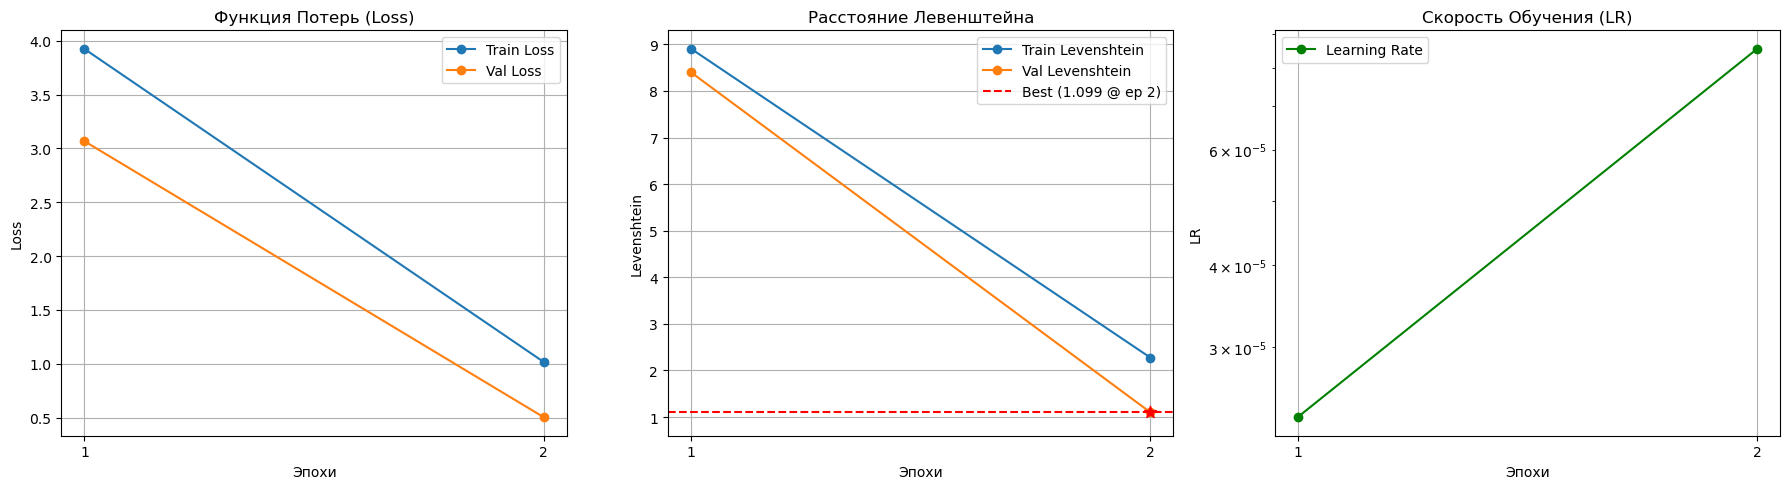


--- Ячейка 13: Основной цикл обучения завершен ---
--------------------------------------------------


In [ ]:
# =============================================================================
# Ячейка 13: Основной Цикл Обучения
# =============================================================================
print("--- Ячейка 13: Запуск Основного Цикла Обучения ---")

# --- Проверки готовности ---
required_vars = [
    'model_created_successfully', 'model', 'criterion', 'optimizer',
    'train_df', 'index_to_char', 'char_to_index', 'AUDIO_CONFIG', 'MODEL_CONFIG', 'TRAIN_CONFIG',
    'device', 'collate_fn', 'MorseDataset', 'train_epoch', 'validate_epoch',
    'BEST_MODEL_PATH', 'PARAMS_PATH', 'EXTRACTED_AUDIO_DIR',
    'BLANK_IDX', 'PAD_IDX'
]
missing_vars = [v for v in required_vars if v not in globals() or globals()[v] is None]
if missing_vars:
     raise SystemExit(f"Остановка: Отсутствуют необходимые компоненты для обучения: {missing_vars}")
if not model_created_successfully:
     raise SystemExit("Остановка: Модель не была успешно создана.")

# --- Подготовка Dataset и DataLoaders ---
train_loader, val_loader = None, None
main_loaders_ready = False
print("\nПодготовка Dataset и DataLoaders...")
try:
    # Создаем Dataset с финальной конфигурацией
    full_train_dataset = MorseDataset(
        dataframe=train_df,
        audio_dir=EXTRACTED_AUDIO_DIR,
        char_to_index=char_to_index,
        audio_config=AUDIO_CONFIG, # Финальная конфигурация
        model_input_feature_dim=MODEL_CONFIG['input_feature_dim'],
        train_config=TRAIN_CONFIG, # Финальная конфигурация
        is_train=True
    )
    print(f"Полный обучающий датасет создан: {len(full_train_dataset)} записей.")
    if len(full_train_dataset) == 0: raise ValueError("Обучающий датасет пуст!")

    # Разделение на train/validation
    dataset_size = len(full_train_dataset)
    val_split_ratio = TRAIN_CONFIG['validation_split_ratio']
    val_size = int(np.floor(val_split_ratio * dataset_size))
    train_size = dataset_size - val_size
    if train_size <= 0 or val_size <= 0:
        raise ValueError(f"Некорректное разделение данных: Train={train_size}, Val={val_size}")
    print(f"Разделение данных: Train={train_size}, Validation={val_size}")

    # Выполняем разделение с фиксированным SEED для воспроизводимости
    train_subset, val_subset = random_split(
        full_train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(TRAIN_CONFIG['base_seed'])
    )

    # Создаем DataLoaders
    main_batch_size = TRAIN_CONFIG['batch_size']
    main_num_workers = TRAIN_CONFIG['num_workers']
    pin_memory_flag = (device.type == 'cuda') # Включаем для ускорения на GPU

    train_loader = DataLoader(
        train_subset, batch_size=main_batch_size, shuffle=True, # Перемешиваем обучающую выборку
        collate_fn=collate_fn, num_workers=main_num_workers, pin_memory=pin_memory_flag
    )
    val_loader = DataLoader(
        val_subset, batch_size=main_batch_size * 2, shuffle=False, # Валидационную не перемешиваем
        collate_fn=collate_fn, num_workers=main_num_workers, pin_memory=pin_memory_flag
    )
    print(f"Созданы Train ({len(train_loader)} батчей) и Val ({len(val_loader)} батчей) DataLoaders.")
    main_loaders_ready = True

except Exception as e:
    print(f"Критическая ошибка при создании Dataset/DataLoaders: {e}")
    traceback.print_exc()
    main_loaders_ready = False

# --- Инициализация Планировщика OneCycleLR ---
scheduler = None
if main_loaders_ready and train_loader is not None:
    try:
        steps_per_epoch = len(train_loader)
        if steps_per_epoch == 0: raise ValueError("Train loader имеет 0 батчей!")
        total_steps = TRAIN_CONFIG['num_epochs'] * steps_per_epoch
        max_lr_scheduler = TRAIN_CONFIG['learning_rate'] # Берем из конфига
        final_div = TRAIN_CONFIG.get('final_div_factor', 1e4) # Берем из конфига (или дефолт)

        print(f"\nИнициализация OneCycleLR: total_steps={total_steps}, max_lr={max_lr_scheduler:.1e}, final_div_factor={final_div:.0f}")
        min_lr_calc = max_lr_scheduler / final_div
        print(f"  Расчетный минимальный LR: {min_lr_calc:.2e}")

        scheduler = OneCycleLR(
            optimizer,
            max_lr=max_lr_scheduler,
            total_steps=total_steps,
            pct_start=0.3,
            anneal_strategy='cos',
            final_div_factor=final_div # !!! Передаем параметр сюда !!!
        )
        print("Планировщик OneCycleLR успешно создан.")
    except Exception as e: print(f"!!! Ошибка инициализации OneCycleLR: {e} !!!"); traceback.print_exc(); scheduler = None; main_loaders_ready = False

# --- Основной Цикл Обучения ---
if main_loaders_ready and scheduler is not None: # Проверяем и scheduler
    print(f"\n--- Начало основного обучения ({TRAIN_CONFIG['num_epochs']} эпох) ---")
    print(f"Модель будет сохранена как: {BEST_MODEL_PATH.name}")
    start_time_total = time.time()
    best_val_levenshtein = float('inf'); epochs_without_improvement = 0
    # Словарь для хранения истории обучения
    training_history = {'train_loss': [], 'train_lev': [], 'val_loss': [], 'val_lev': [], 'lr': []}

    try:
        for epoch in range(1, TRAIN_CONFIG['num_epochs'] + 1):
            epoch_start_time = time.time()
            print(f"\n--- Эпоха {epoch}/{TRAIN_CONFIG['num_epochs']} ---")

            # --- Тренировка ---
            avg_train_loss, avg_train_lev, avg_epoch_lr = train_epoch(
                model=model, dataloader=train_loader, criterion=criterion,
                optimizer=optimizer, scheduler=scheduler, device=device,
                epoch_num=epoch, total_epochs=TRAIN_CONFIG['num_epochs'],
                index_to_char_map=index_to_char, blank_idx=BLANK_IDX, pad_idx=PAD_IDX,
                grad_clip_norm=TRAIN_CONFIG['gradient_clip_norm']
            )

            # --- Валидация ---
            avg_val_loss, avg_val_lev, val_examples = validate_epoch(
                model=model, dataloader=val_loader, criterion=criterion, device=device,
                index_to_char_map=index_to_char, blank_idx=BLANK_IDX, pad_idx=PAD_IDX
            )

            epoch_duration = time.time() - epoch_start_time

            # --- Запись истории ---
            training_history['train_loss'].append(avg_train_loss)
            training_history['train_lev'].append(avg_train_lev)
            training_history['val_loss'].append(avg_val_loss)
            training_history['val_lev'].append(avg_val_lev)
            training_history['lr'].append(avg_epoch_lr) # Записываем средний LR за эпоху

            # --- Вывод результатов эпохи ---
            print(f"\nИтоги Эпохи {epoch}/{TRAIN_CONFIG['num_epochs']} | Время: {epoch_duration:.2f} сек | Ср.LR: {avg_epoch_lr:.3e}")
            print(f"  Train Loss: {avg_train_loss:.4f} | Train Levenshtein: {avg_train_lev:.4f}")
            print(f"  Val Loss:   {avg_val_loss:.4f} | Val Levenshtein:   {avg_val_lev:.4f}")
            print("  Примеры декодирования (Greedy):")
            for i, (pred, real) in enumerate(val_examples[:5]): # Выводим первые 5 пар
                print(f"    {i+1}: '{pred[:70]}' | '{real[:70]}'") # Ограничиваем длину вывода

            # --- Сохранение лучшей модели и Early Stopping ---
            # Проверяем, что val_lev конечен и меньше текущего лучшего
            if np.isfinite(avg_val_lev) and avg_val_lev < best_val_levenshtein:
                print(f"  ✨ Val Lev улучшился: {best_val_levenshtein:.4f} -> {avg_val_lev:.4f}. Сохранение модели...")
                best_val_levenshtein = avg_val_lev
                try:
                    # Сохраняем только state_dict модели
                    torch.save(model.state_dict(), BEST_MODEL_PATH)
                    print(f"  Модель сохранена в: {BEST_MODEL_PATH}")
                except Exception as save_err:
                    print(f"  !!! Ошибка при сохранении модели: {save_err} !!!")
                epochs_without_improvement = 0 # Сбрасываем счетчик
            else:
                epochs_without_improvement += 1
                print(f"  Val Lev не улучшился ({avg_val_lev:.4f} vs best {best_val_levenshtein:.4f}). Эпох без улучшений: {epochs_without_improvement}/{TRAIN_CONFIG['early_stopping_patience']}")

            # Проверка условия для ранней остановки
            if epochs_without_improvement >= TRAIN_CONFIG['early_stopping_patience']:
                print(f"\n❗️ Ранняя остановка! Нет улучшений Val Levenshtein в течение {TRAIN_CONFIG['early_stopping_patience']} эпох.")
                break # Прерываем цикл обучения
            print("-" * 60)

    except KeyboardInterrupt:
        print("\nОбучение прервано пользователем (KeyboardInterrupt).")
    except RuntimeError as e:
        # Обработка OOM отдельно для информативности
        if "CUDA out of memory" in str(e):
             print("\n!!! Критическая ошибка: CUDA out of memory! Обучение остановлено. Попробуйте уменьшить batch_size. !!!")
        else:
             print(f"\n!!! Обучение прервано из-за RuntimeError: {e} !!!")
             traceback.print_exc()
    except Exception as train_err:
        print(f"\n!!! КРИТИЧЕСКАЯ НЕПРЕДВИДЕННАЯ ОШИБКА ОБУЧЕНИЯ: {train_err} !!!")
        traceback.print_exc()
    finally:
         # Этот блок выполнится всегда: при нормальном завершении, break, return или ошибке
         total_training_time = time.time() - start_time_total
         print(f"\n--- Основное Обучение Завершено ---")
         print(f"Общее время обучения: {total_training_time / 60:.2f} мин")
         best_lev_str = f"{best_val_levenshtein:.4f}" if np.isfinite(best_val_levenshtein) else "N/A"
         print(f"Лучший достигнутый Val Levenshtein: {best_lev_str}")
         if np.isfinite(best_val_levenshtein):
             print(f"Лучшая модель (state_dict) сохранена в: {BEST_MODEL_PATH}")

         # --- Сохранение финальных параметров ---
         print("\nСохранение финальных параметров конфигурации...")
         # Собираем все параметры в один словарь для удобства
         # Убедимся, что сохраняем словари, а не объекты Path
         final_params_to_save = {
             'audio_config': AUDIO_CONFIG,
             'model_config': MODEL_CONFIG,
             'train_config': TRAIN_CONFIG,
             'char_map': { # Сохраняем словари и индексы
                 'char_to_index': char_to_index,
                 'index_to_char': {k:v for k,v in index_to_char.items()}, # Копируем на всякий случай
                 'BLANK_IDX': BLANK_IDX,
                 'PAD_IDX': PAD_IDX,
                 'NUM_CLASSES_CTC': NUM_CLASSES_CTC
             },
             'best_val_levenshtein': best_val_levenshtein if np.isfinite(best_val_levenshtein) else None
         }
         try:
             with open(PARAMS_PATH, 'w', encoding='utf-8') as f:
                 # Используем json.dump для сохранения словаря
                 json.dump(final_params_to_save, f, indent=4, ensure_ascii=False)
             print(f"Параметры конфигурации сохранены в: {PARAMS_PATH}")
         except Exception as e:
             print(f"!!! Ошибка при сохранении параметров конфигурации: {e} !!!")

         # --- Построение графиков обучения ---
         print("\nПостроение графиков истории обучения...")
         epochs_completed = len(training_history['train_loss'])
         if epochs_completed > 0:
             epoch_axis = range(1, epochs_completed + 1)
             plt.figure(figsize=(18, 5)) # Широкий график

             # График Потерь (Loss)
             plt.subplot(1, 3, 1)
             plt.plot(epoch_axis, training_history['train_loss'], 'o-', label='Train Loss')
             plt.plot(epoch_axis, training_history['val_loss'], 'o-', label='Val Loss')
             plt.title('Функция Потерь (Loss)'); plt.xlabel('Эпохи'); plt.ylabel('Loss')
             plt.legend(); plt.grid(True);
             plt.xticks(np.arange(1, epochs_completed + 1, step=max(1, epochs_completed//10)))

             # График Метрики (Levenshtein)
             plt.subplot(1, 3, 2)
             plt.plot(epoch_axis, training_history['train_lev'], 'o-', label='Train Levenshtein')
             plt.plot(epoch_axis, training_history['val_lev'], 'o-', label='Val Levenshtein')
             # Отмечаем лучший результат на графике
             if np.isfinite(best_val_levenshtein):
                 best_epoch = np.argmin(training_history['val_lev']) + 1
                 plt.axhline(y=best_val_levenshtein, color='r', linestyle='--', label=f'Best ({best_val_levenshtein:.3f} @ ep {best_epoch})')
                 plt.scatter(best_epoch, best_val_levenshtein, color='red', s=80, zorder=5, marker='*') # Отмечаем звездочкой
             plt.title('Расстояние Левенштейна'); plt.xlabel('Эпохи'); plt.ylabel('Levenshtein')
             plt.legend(); plt.grid(True);
             plt.xticks(np.arange(1, epochs_completed + 1, step=max(1, epochs_completed//10)))
             min_val_lev = min(training_history['val_lev']) if training_history['val_lev'] else 0
             plt.ylim(bottom=max(0, min_val_lev - 0.5)) # Устанавливаем разумный нижний предел оси Y

             # График Скорости Обучения (Learning Rate)
             plt.subplot(1, 3, 3)
             plt.plot(epoch_axis, training_history['lr'], 'o-', label='Learning Rate', color='g')
             plt.title('Скорость Обучения (LR)'); plt.xlabel('Эпохи'); plt.ylabel('LR')
             plt.legend(); plt.grid(True);
             plt.yscale('log') # Логарифмическая шкала для LR
             plt.xticks(np.arange(1, epochs_completed + 1, step=max(1, epochs_completed//10)))

             plt.tight_layout() # Автоматическое расталкивание графиков
             plt.show()
         else:
             print("Нет данных для построения графиков (обучение не запускалось или прервалось на 1й эпохе).")

else:
    print("\n--- Основное Обучение Не Запущено (проблемы с подготовкой данных или инициализацией планировщика) ---")

print("\n--- Ячейка 13: Основной цикл обучения завершен ---")
print("-" * 50)
# =============================================================================

### Ячейка 14: Генерация Предсказаний (Submission)

In [ ]:
# =============================================================================
# Ячейка 14: Генерация Предсказаний (Submission)
# =============================================================================
print("--- Ячейка 14: Генерация Предсказаний для Теста (Greedy) ---")

# --- Проверки наличия файлов и переменных ---
# Убедимся, что все компоненты, необходимые для инференса, доступны
required_infer_vars = [
    'BEST_MODEL_PATH', 'PARAMS_PATH', 'test_df', 'MorseRecognizer',
    'MorseDataset', 'collate_fn', 'device', 'ctc_greedy_decode',
    'index_to_char', 'BLANK_IDX', 'PAD_IDX', 'tqdm', 'torch', 'json', 'Path',
    'pd', 'DataLoader', 'np', 'EXTRACTED_AUDIO_DIR', 'TRAIN_CONFIG', 'F',
    'MODEL_CONFIG', 'OUTPUT_DIR'
]
missing_infer_vars = [v for v in required_infer_vars if v not in globals() or globals()[v] is None]
model_file_exists = 'BEST_MODEL_PATH' in globals() and BEST_MODEL_PATH is not None and isinstance(BEST_MODEL_PATH, Path) and BEST_MODEL_PATH.is_file()
params_file_exists = 'PARAMS_PATH' in globals() and PARAMS_PATH is not None and isinstance(PARAMS_PATH, Path) and PARAMS_PATH.is_file()
test_df_exists = 'test_df' in globals() and test_df is not None and not test_df.empty

can_infer = not missing_infer_vars and model_file_exists and params_file_exists and test_df_exists

if can_infer:
    print(f"Загрузка лучшей модели из: {BEST_MODEL_PATH}")
    print(f"Загрузка параметров из: {PARAMS_PATH}")
    print("Декодирование будет выполняться с помощью: Greedy")

    # --- Загрузка параметров конфигурации из файла JSON ---
    print("\n1. Загрузка параметров конфигурации...")
    loaded_params_infer = None; params_loaded_successfully = False
    try:
        with open(PARAMS_PATH, 'r', encoding='utf-8') as f:
            loaded_params_infer = json.load(f)
        # Извлекаем необходимые словари и значения
        loaded_audio_config_inf = loaded_params_infer['audio_config']
        loaded_model_config_inf = loaded_params_infer['model_config']
        loaded_char_map_inf = loaded_params_infer['char_map']
        # Важно восстановить словари и индексы из файла
        loaded_char_to_index_inf = loaded_char_map_inf['char_to_index']
        # Восстанавливаем index_to_char, преобразуя ключи обратно в int, если нужно
        loaded_index_to_char_inf = {int(k) if k.isdigit() else k: v for k,v in loaded_char_map_inf['index_to_char'].items()}
        loaded_blank_idx_inf = loaded_char_map_inf['BLANK_IDX']
        loaded_pad_idx_inf = loaded_char_map_inf['PAD_IDX']
        loaded_num_classes_inf = loaded_char_map_inf['NUM_CLASSES_CTC']
        loaded_input_dim_inf = loaded_model_config_inf['input_feature_dim']
        print("   Параметры успешно загружены.")
        params_loaded_successfully = True
    except FileNotFoundError:
        print(f"   !!! Ошибка: Файл параметров не найден по пути {PARAMS_PATH} !!!")
    except Exception as e:
        print(f"   !!! Ошибка при загрузке или парсинге файла параметров: {e} !!!")
        traceback.print_exc(limit=1)

    # --- Создание модели и загрузка весов ---
    inference_model = None; model_loaded_for_inference = False
    if params_loaded_successfully:
        print(f"\n2. Создание модели для инференса...")
        try:
            # Создаем модель с загруженными параметрами
            temp_model_config_for_init = loaded_model_config_inf.copy()
            # input_feature_dim передается отдельно в конструктор
            temp_model_config_for_init.pop('input_feature_dim', None)
            inference_model = MorseRecognizer(
                num_classes_ctc=loaded_num_classes_inf,
                input_feature_dim=loaded_input_dim_inf,
                **temp_model_config_for_init
            ).to(device)

            print(f"   Загрузка весов из файла: {BEST_MODEL_PATH}...")
            # Загружаем state_dict (сохраненные веса)
            # Используем weights_only=True для безопасности, если поддерживается
            try:
                inference_model.load_state_dict(
                    torch.load(BEST_MODEL_PATH, map_location=device, weights_only=True)
                )
            except TypeError: # Обработка для старых версий PyTorch
                print("   Warning: weights_only=True не поддерживается. Загрузка стандартным способом.")
                inference_model.load_state_dict(
                    torch.load(BEST_MODEL_PATH, map_location=device)
                )

            inference_model.eval() # !!! Перевод модели в режим инференса !!!
            print("   Модель успешно создана и веса загружены.")
            model_loaded_for_inference = True
        except FileNotFoundError:
             print(f"   !!! Ошибка: Файл модели не найден по пути {BEST_MODEL_PATH} !!!")
        except Exception as e:
            print(f"   !!! Ошибка при создании или загрузке весов модели: {e} !!!")
            traceback.print_exc(limit=1)

    # --- Создание тестового DataLoader ---
    test_loader_infer = None; test_loader_ready = False
    if model_loaded_for_inference:
        print("\n3. Создание тестового DataLoader...")
        try:
             # Используем загруженные конфигурации для создания датасета
             # train_config нужен для noise_level (который будет 0)
             loaded_train_config_inf = loaded_params_infer.get('train_config', TRAIN_CONFIG)

             infer_test_dataset = MorseDataset(
                 dataframe=test_df,
                 audio_dir=EXTRACTED_AUDIO_DIR,
                 char_to_index=loaded_char_to_index_inf,
                 audio_config=loaded_audio_config_inf,
                 model_input_feature_dim=loaded_input_dim_inf,
                 train_config=loaded_train_config_inf, # Передаем для консистентности
                 is_train=False # Указываем, что это режим инференса
             )
             # Увеличиваем batch_size для ускорения инференса
             inference_batch_size = TRAIN_CONFIG.get('batch_size', 8) * 4
             inf_num_workers = TRAIN_CONFIG.get('num_workers', 0)
             test_loader_infer = DataLoader(
                 infer_test_dataset,
                 batch_size=inference_batch_size,
                 shuffle=False, # Тестовую выборку не перемешиваем
                 collate_fn=collate_fn,
                 num_workers=inf_num_workers,
                 pin_memory=(device.type == 'cuda') # Ускорение для GPU
             )
             print(f"   Тестовый DataLoader создан (Размер батча={inference_batch_size}).")
             test_loader_ready = True
        except Exception as e:
            print(f"   !!! Ошибка при создании тестового DataLoader: {e} !!!")
            traceback.print_exc(limit=1)

    # --- Запуск Инференса ---
    if test_loader_ready and inference_model is not None:
        predictions = {} # Словарь для хранения {file_id: predicted_text}
        print("\n4. Запуск инференса (предсказания на тестовых данных)...")
        inference_start_time = time.time()
        inference_model.eval(); # Убедимся еще раз, что модель в режиме eval

        with torch.no_grad(): # Отключаем расчет градиентов
            pbar_infer = tqdm(test_loader_infer, desc="Предсказание (Greedy)", ncols=100, leave=True)
            for batch_data in pbar_infer:
                if batch_data is None: continue # Пропускаем пустые батчи от collate_fn
                features, file_ids, feature_lengths, _ = batch_data
                if features is None or file_ids is None or features.shape[0]==0: continue

                features = features.to(device, non_blocking=True)

                try:
                    # Получаем логиты от модели
                    logits = inference_model(features) # (Time, B, Classes)
                    # Декодируем с помощью Greedy
                    decoded_batch = ctc_greedy_decode(
                        logits,
                        loaded_index_to_char_inf, # Используем загруженный словарь
                        loaded_blank_idx_inf      # Используем загруженный индекс BLANK
                    )
                except Exception as e:
                    print(f"\nОшибка Forward/Decode в батче инференса: {e}")
                    traceback.print_exc(limit=1)
                    # Записываем ошибку для всех ID в этом батче
                    for fid in file_ids: predictions[fid] = f"ERROR_INFER"
                    continue # Переходим к следующему батчу

                # Сохраняем предсказания для батча
                for file_id, pred_text in zip(file_ids, decoded_batch):
                    predictions[file_id] = pred_text

        inference_duration = time.time() - inference_start_time
        print(f"\n   Инференс завершен за {inference_duration:.2f} сек.")
        print(f"   Предсказаний В СЛОВАРЕ: {len(predictions)} (ожидалось: {len(test_df)})")
        if len(predictions) != len(test_df):
             print("   !!! Предупреждение: Количество предсказаний не совпадает с размером тестового датасета! Возможны ошибки в обработке части файлов. !!!")

        # --- Формирование и сохранение submission ---
        if predictions:
            print("\n5. Формирование и сохранение файла submission...")
            # Создаем DataFrame на основе оригинального test_df для сохранения порядка ID
            submission_df = pd.DataFrame({'id': test_df['id']})
            # Заполняем колонку 'message', используя словарь predictions
            # .map() сопоставляет id с ключами словаря predictions
            # .fillna("") обрабатывает ID, для которых не нашлось предсказания (не должно быть при len=5000)
            submission_df['message'] = submission_df['id'].map(predictions).fillna("ERROR_MISSING_PRED")

            # Проверка на пустые строки или ошибки
            num_empty = (submission_df['message'] == "").sum()
            num_errors = submission_df['message'].str.contains("ERROR").sum()
            if num_empty > 0: print(f"  Предупреждение: Найдено {num_empty} пустых предсказаний.")
            if num_errors > 0: print(f"  Предупреждение: Найдено {num_errors} предсказаний с ошибками.")

            # Формируем имя файла submission, включающее параметры
            submission_filename = f"submission_greedy_{FINAL_SUFFIX}.csv"
            submission_path = OUTPUT_DIR / submission_filename
            try:
                submission_df.to_csv(submission_path, index=False)
                print(f"   Файл submission успешно сохранен: {submission_path.resolve()}")

                # Вывод ПОСЛЕДНИХ 17 строк для проверки
                print(f"\n   Последние {min(17, len(submission_df))} строк файла submission:")
                display(submission_df.tail(17)) # Используем .tail()

            except Exception as e:
                print(f"   !!! Ошибка при сохранении файла submission: {e} !!!")
        else:
            print("   Предсказания не были сгенерированы, файл submission не создан.")

# Обработка случая, если инференс не мог быть запущен
elif not can_infer:
    print("\n--- Инференс Не Запущен ---")
    if missing_infer_vars: print(f"  Причина: Отсутствуют необходимые переменные: {missing_infer_vars}")
    if not model_file_exists: print(f"  Причина: Файл лучшей модели не найден: {globals().get('BEST_MODEL_PATH', 'Путь не определен')}")
    if not params_file_exists: print(f"  Причина: Файл параметров не найден: {globals().get('PARAMS_PATH', 'Путь не определен')}")
    if not test_df_exists: print("  Причина: Тестовый DataFrame (test_df) не загружен или пуст.")

print("\n--- Ячейка 14: Работа ноутбука завершена ---")
print("=" * 60)
# =============================================================================

--- Ячейка 14: Генерация Предсказаний для Теста (Greedy) ---
Модель для инференса: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\model_Filt0-3996Hz_RMS384h96_CNNk9p2_RNN256x2_Feat2_WD1e-04_Deltastandard.pth
Параметры для инференса: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\params_Filt0-3996Hz_RMS384h96_CNNk9p2_RNN256x2_Feat2_WD1e-04_Deltastandard.json
Используется ТОЛЬКО Greedy декодер.

Загрузка сохраненных параметров...
Параметры успешно загружены.

Создание модели для инференса...
Архитектура MorseRecognizer инициализирована.
Загрузка весов из файла: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\model_Filt0-3996Hz_RMS384h96_CNNk9p2_RNN256x2_Feat2_WD1e-04_Deltastandard.pth...
Модель успешно создана и веса загружены.

Создание тестового DataLoader...
MorseDataset создан: is_train=False, delta_type='standard', rms_smooth=Нет, delta_smooth=Нет, noise_level=Отключен
Тестовый DataLoader создан (BS=32).

--- Запуск инференса (Greedy) ---


Предсказание (Greedy):   0%|                                                | 0/157 [00:00<?, ?it/s]


Инференс (Greedy) завершен за 36.95 сек. Предсказаний В СЛОВАРЕ: 5000/5000

Формирование файла submission.csv...
Файл submission сохранен: C:\Users\vasja\OneDrive\Рабочий стол\MorseAudioDecoder\output\submission_greedy__Deltastandard.csv

Последние 17 строк файла submission:


,id,message
4983,34984.opus,ДАМАМТЗОТИ РСЫСАМЦ
4984,34985.opus,ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМ Ь#ЧМЫН Д#МРГ...
4985,34986.opus,АНХ ВСОЕГЬ Р ВКТДАМИРКШМДНИ ГКНЖТА
4986,34987.opus,ИЛ ДАСДП ЬСОЕМУНТА ИГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХНУСИ
4987,34988.opus,ЕТЬТКП ДСЯНКМЫОЦ ИМК
4988,34989.opus,КНОЬКМ СОЕНЫМОП ЬСЮНВМ
4989,34990.opus,ИЛ ЬСОЕНДМ#М ЙЫНУС ЙЫМЧАТУС ЬКТДЛХТ ЫМЖАЛШ ДЛУ...
4990,34991.opus,Л ДАСДП ОСЮВНЫМ НЮЙГРГ ТЫТУКНЩН
4991,34992.opus,АСТ ИСЧТИ ГЖГПЦ Ю НЙОСЫЗЕПЗ ККАСОЕПЙМИДСЫС
4992,34993.opus,ОЫДЛ ЫЛ1ЕТ #КС ЬЙЫНТ ЕСЕРЫ9АМЕ0П



--- Ячейка 14: Работа ноутбука завершена (Greedy) ---
